In [1]:
import DataLoader, Training, os, warnings, sklearn
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import captum, torch, mne
from torch.utils.data import TensorDataset
from captum.attr import Saliency, DeepLift
from matplotlib import cm
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap

In [15]:
#plt.rcParams.update(plt.rcParamsDefault)
def plot_attribution(attribution, task, title=None):
    sns.reset_orig()
    plt.figure(figsize=(20, 5))
    if title != None:
        plt.title(title)
    if task == "LRP":
        plt.xticks(np.arange(0, 251, step=25),np.round(np.arange(-0.8, 0.21, step=0.1),2))
    elif task == "ERN":
        plt.xticks(np.arange(0, 251, step=25),np.round(np.arange(-0.6, 0.41, step=0.1),2))
    else:
        plt.xticks(np.arange(0, 251, step=25),np.round(np.arange(-0.2, 0.81, step=0.1),2))
    plt.ylabel('Electrode')
    plt.xlabel('Seconds')
    plt.yticks(np.arange(0, 30, step=1),
           ['FP1','F3','F7','FC3','C3','C5','P3','P7','P9','PO7',
            'PO3','O1','Oz','Pz','CPz','FP2','Fz','F4','F8','FC4',
            'FCz','Cz','C4','C6','P4','P8','P10','PO8','PO4','O2',])
    vabs = max(abs(attribution.min()),abs(attribution.max()))
    plt.imshow(attribution[0,:,:].detach().numpy(),aspect="auto",cmap="vlag_r", interpolation="none",vmin=-vabs,vmax=vabs)
    plt.colorbar(label="Attribution", pad=0.005)
    
def plot_topo(attribution, task, title=None, timestamps=True):
    raw = DataLoader.load_raw(data_path, task, "medium", "001")
    #epochs = DataLoader.epoch_raw(raw, task, "medium")
    
    sns.reset_orig()
    fig, axes = plt.subplots(1, 10, figsize=(18, 2), dpi=100)
    if title != None:
        fig.suptitle(title)
    for i in range(0,10):
        vabs = max(abs(attribution.min()),abs(attribution.max()))
        mne.viz.plot_topomap(attribution.detach().numpy()[:,:,i*25:i*25+25].mean(axis=2).reshape(30,), raw.info,
                             vmin=-vabs,vmax=vabs,
                             names=raw.info.ch_names, axes=axes[i], show=False, cmap="vlag_r")
        if timestamps:
            if task == "LRP":
                axes[i].set_title(str(i*100-800)+"ms to "+str(i*100-700)+"ms", y=-0.3)
            elif task == "ERN":
                axes[i].set_title(str(i*100-600)+"ms to "+str(i*100-500)+"ms", y=-0.3)
            else:
                axes[i].set_title(str(i*100-200)+"ms to "+str(i*100-100)+"ms", y=-0.3)


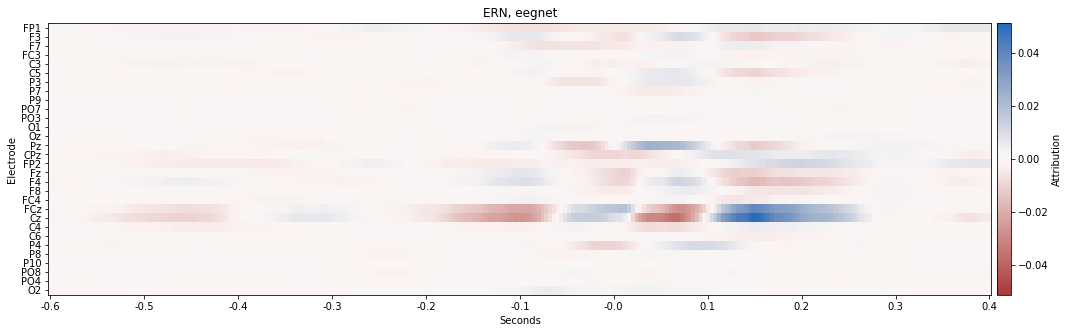

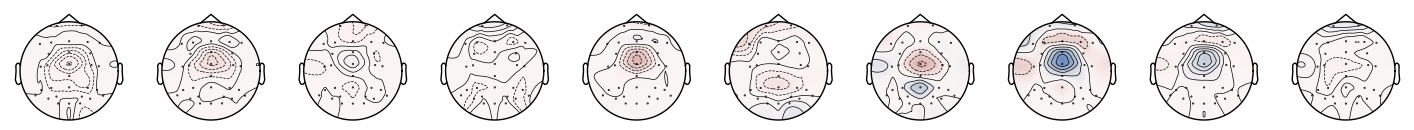

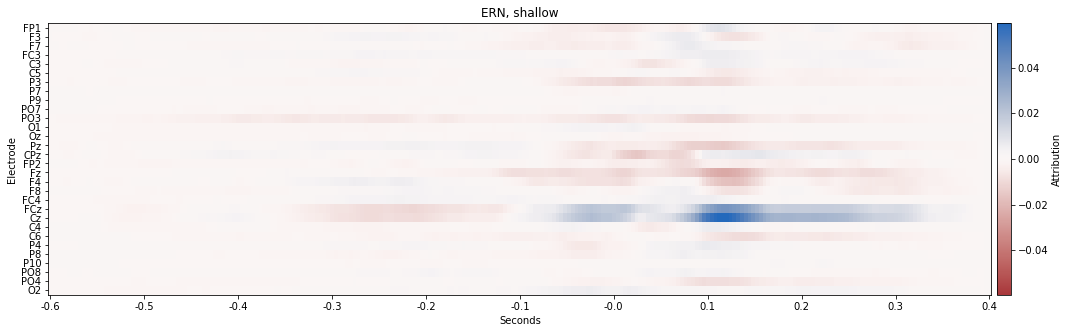

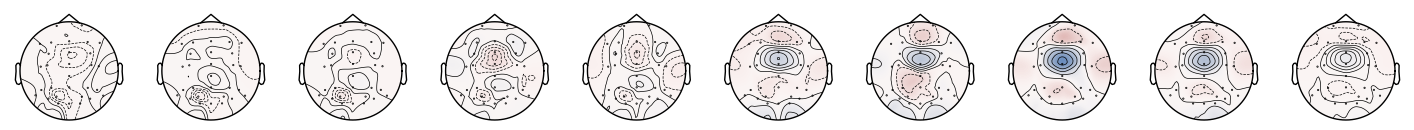

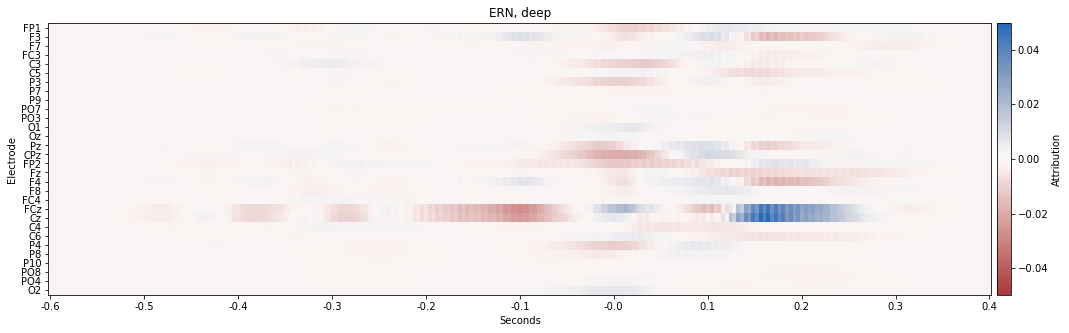

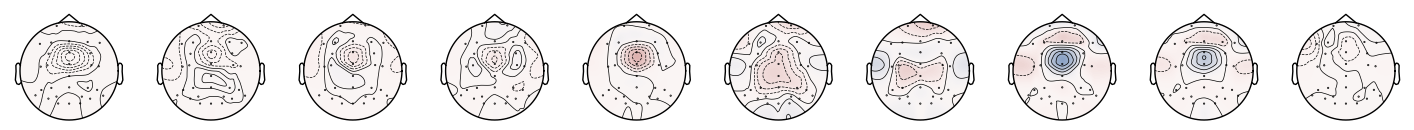

In [28]:
## P3 test 
data_path = "F:/Masterthesis/Data/"
preprocessing = "heavy"
model_folder = "ModelComparison"
n_samples = 1000
task = "ERN"

for model_name in ["eegnet","shallow","deep"]:
    df = DataLoader.load_df(data_path, task, preprocessing)
    df = df.sample(n_samples, random_state=42)
    data, labels = DataLoader.create_data_labels(df)

    clf, model = Training.init_model(model_name, lr=0.01, gpu=False)
    model_path = os.getcwd()+"\\"+model_folder+"\\"+model_name+"\\"+task+"\\"+preprocessing+"\\"
    clf.load_params(f_params=model_path+"split_"+str(1)+"_model.pkl",
                           f_optimizer=model_path+"split_"+str(1)+"_optimizer.pkl",
                           f_history=model_path+"split_"+str(1)+"_history.json") 
    #data = data[np.where(clf.predict(data)==labels)[0]]

    dl = DeepLift(model)
    attribution = 0
    for i in range(len(data)):
        tensor = torch.from_numpy(data[i].reshape(1,30,251)).float()
        tensor.requires_grad = True
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            attribution += (dl.attribute(tensor, target=1)-dl.attribute(tensor, target=0))
            #attribution += abs(dl.attribute(tensor, target=0))
    attribution = attribution/n_samples
    plot_attribution(attribution, task, title=task+", "+model_name)
    plt.savefig("Plots/Model/"+task+"_"+model_name+"_attribution.png")
    plot_topo(attribution, task, timestamps=False)
    plt.savefig("Plots/Model/"+task+"_"+model_name+"_topo.png")

C:\Users\vapor\anaconda3\envs\braindecode\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
<ipython-input-2-f6758c3036a0>:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(20, 5))


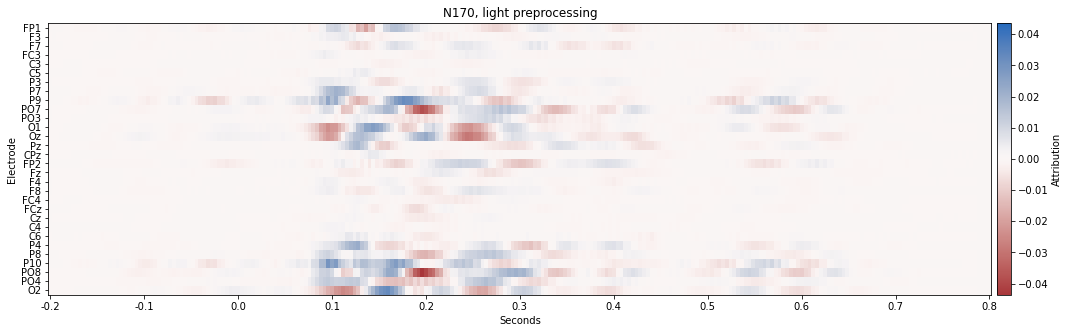

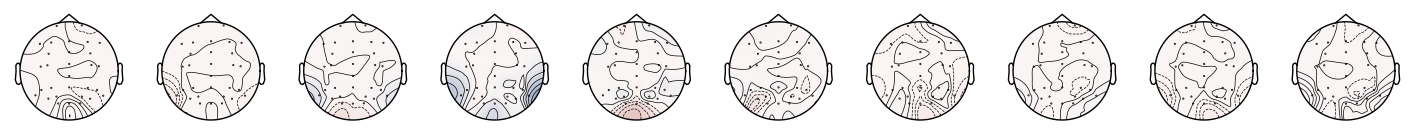

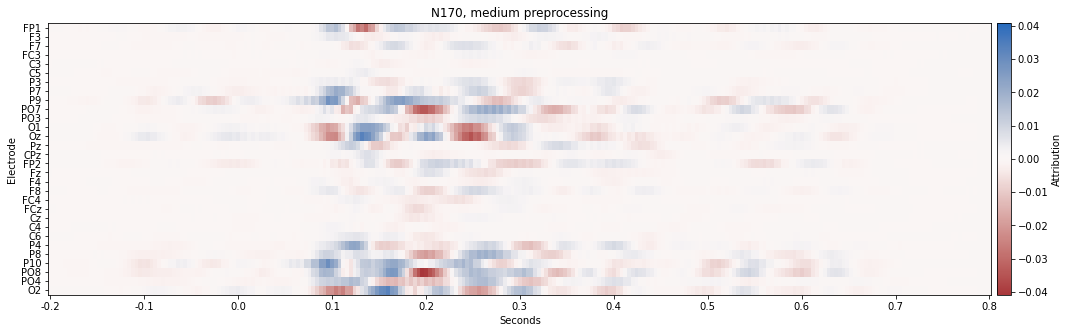

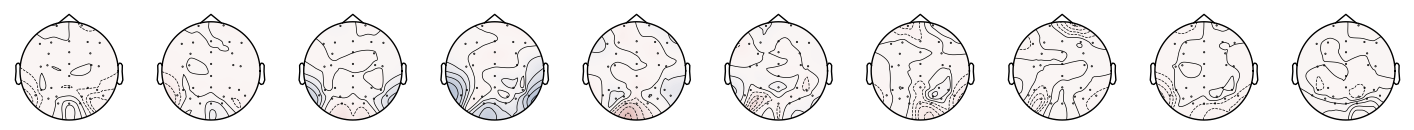

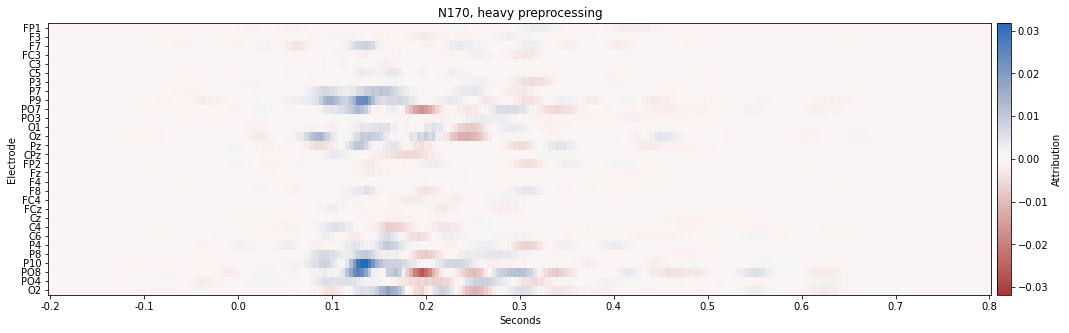

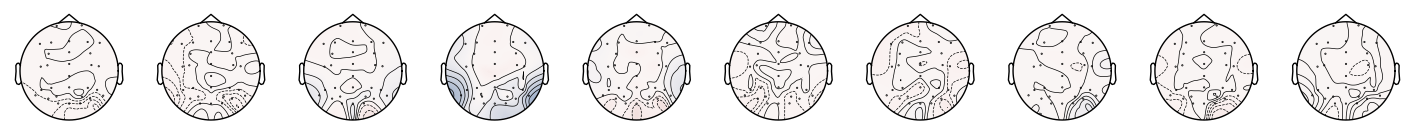

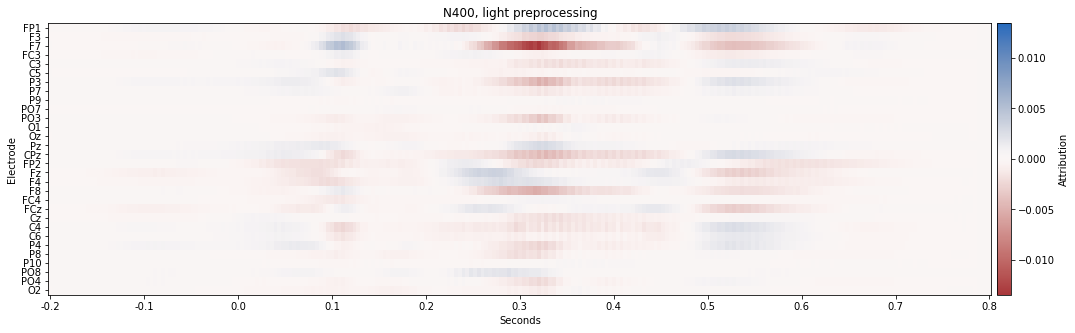

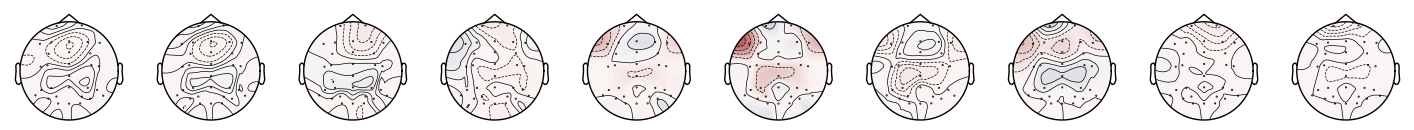

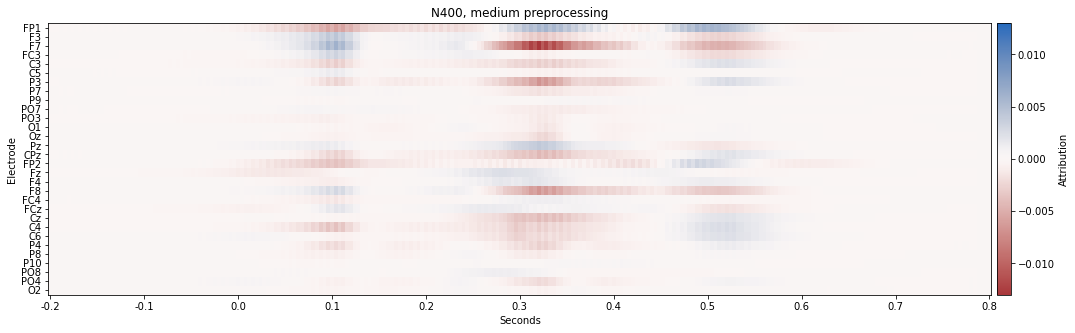

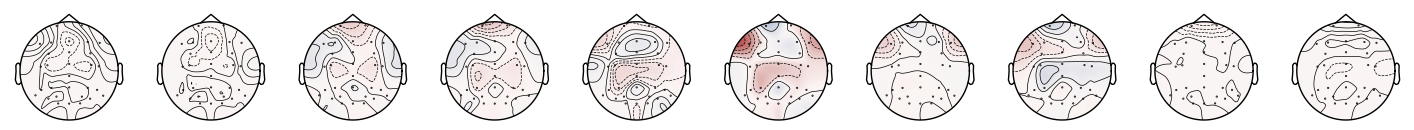

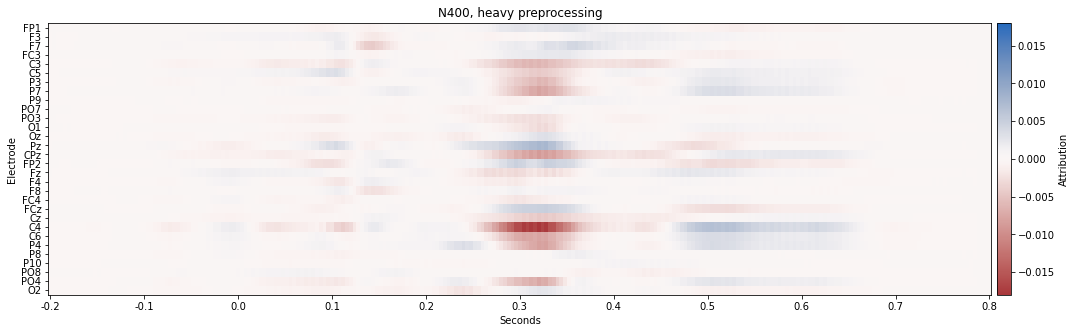

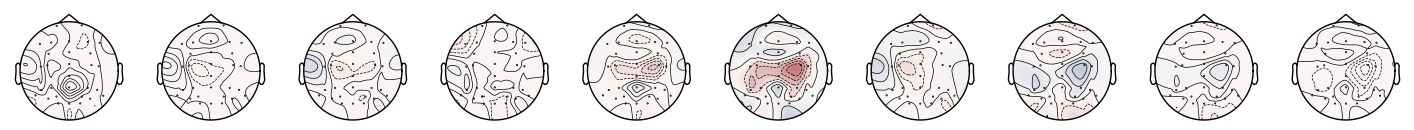

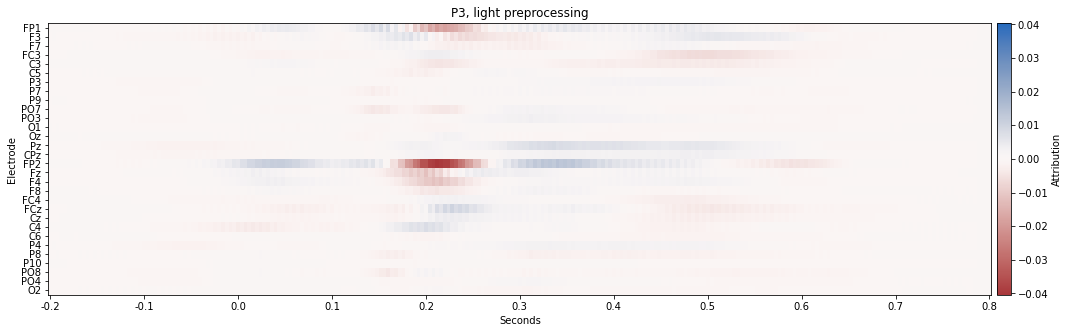

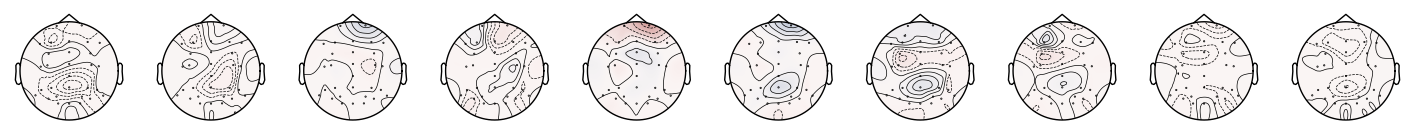

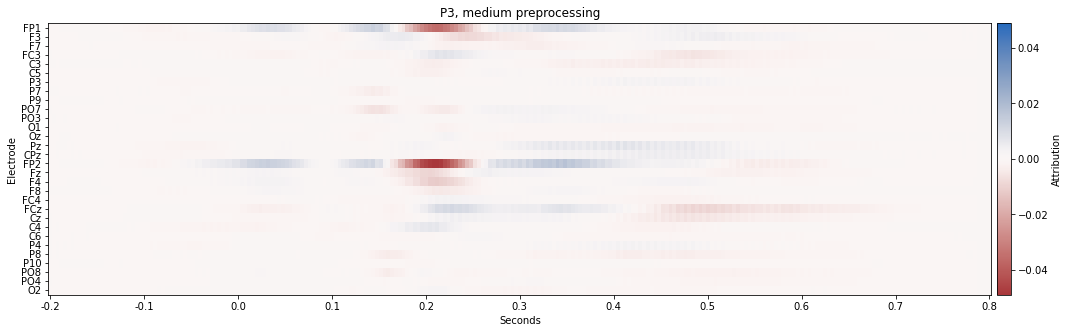

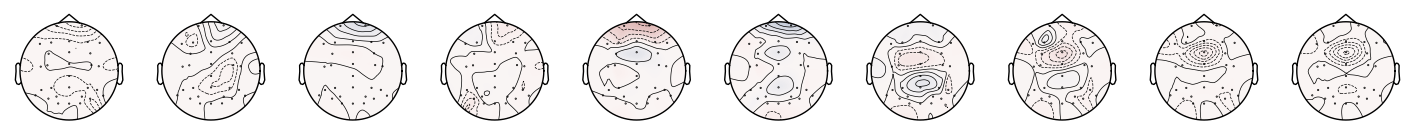

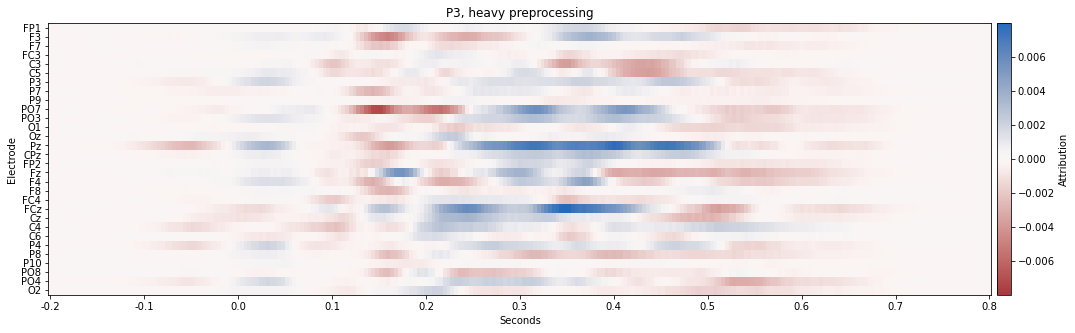

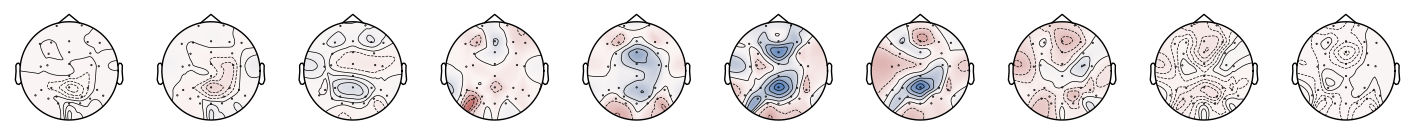

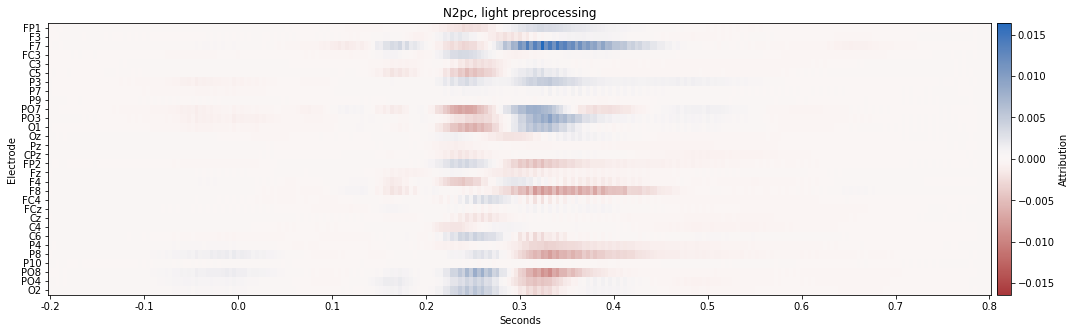

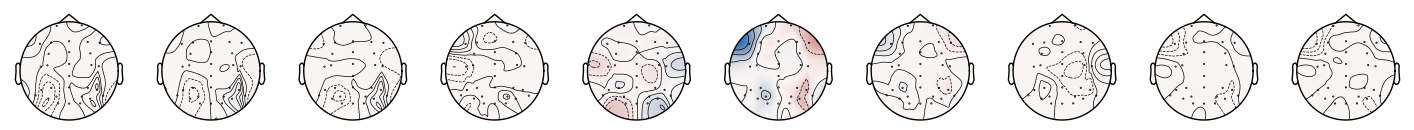

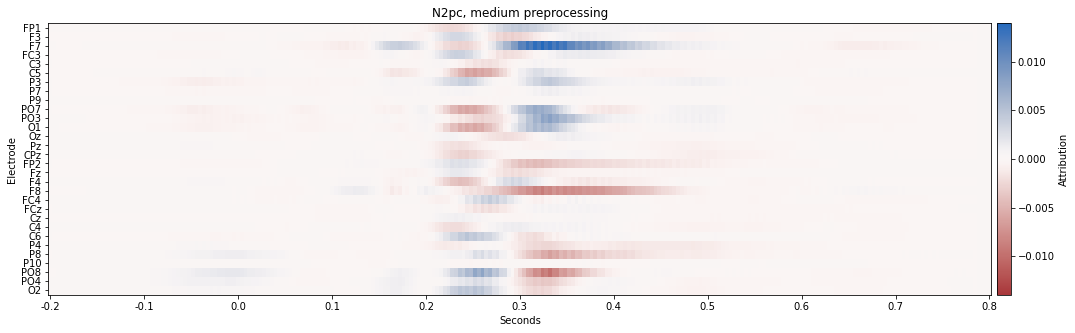

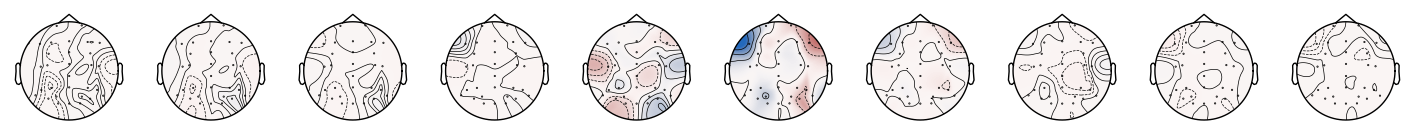

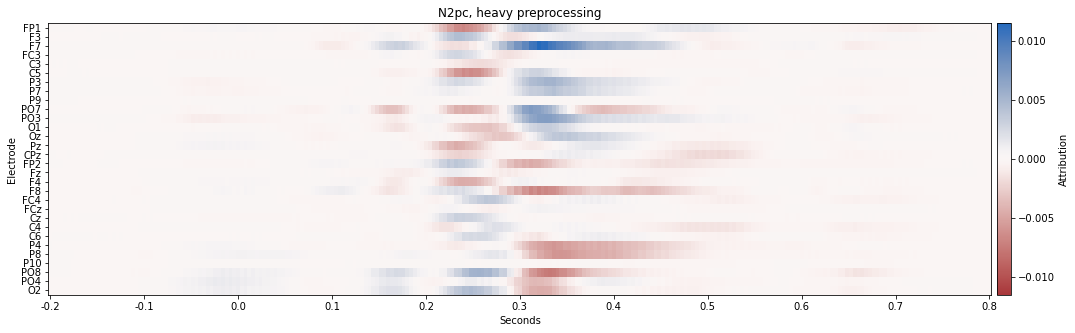

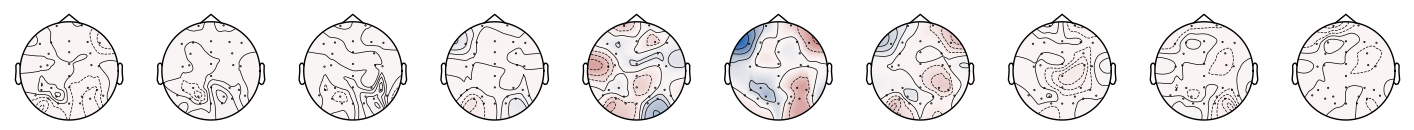

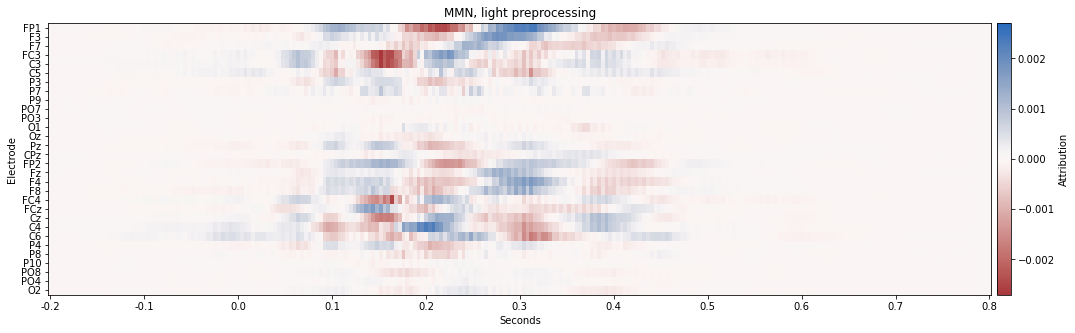

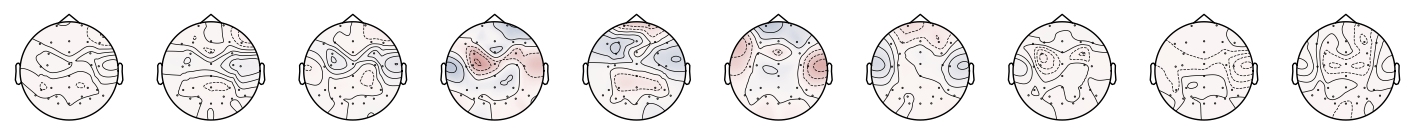

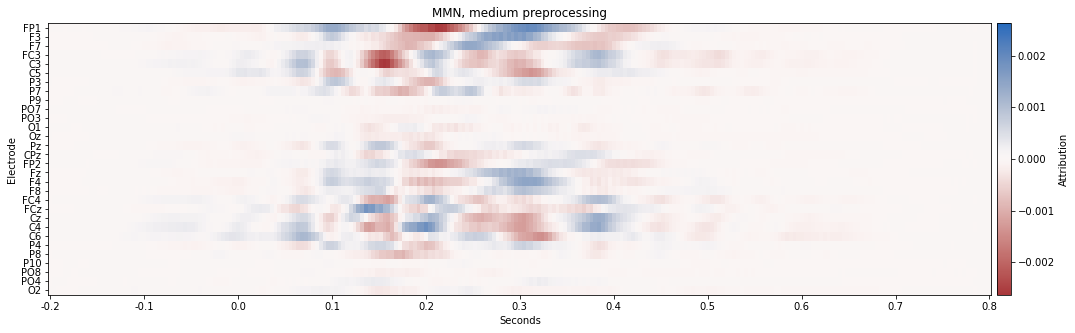

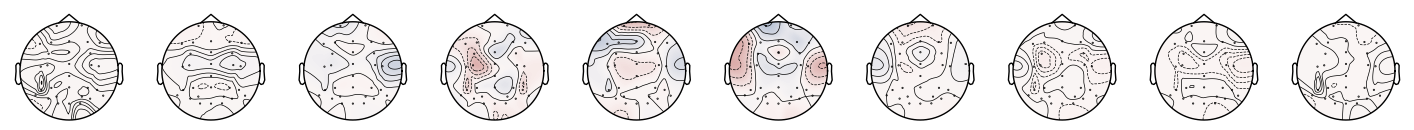

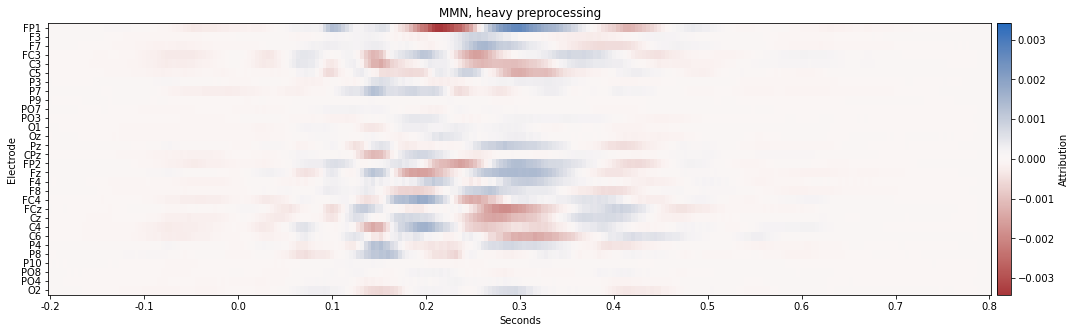

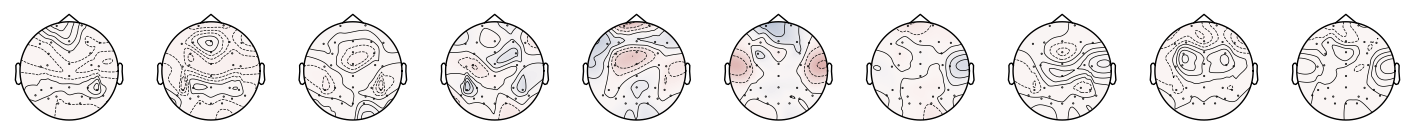

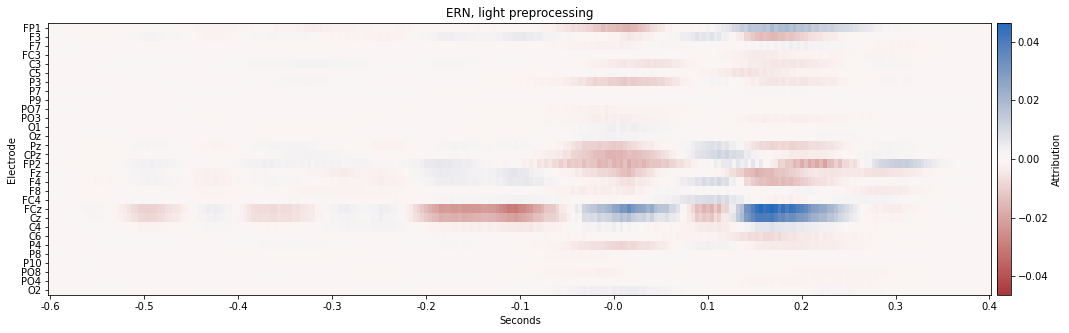

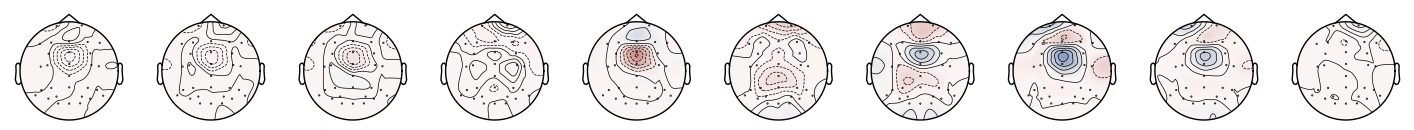

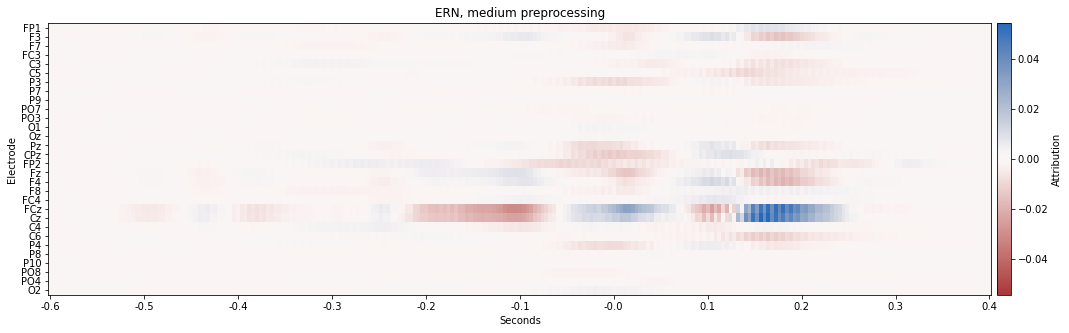

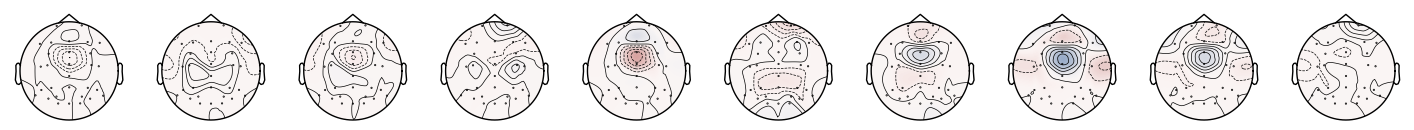

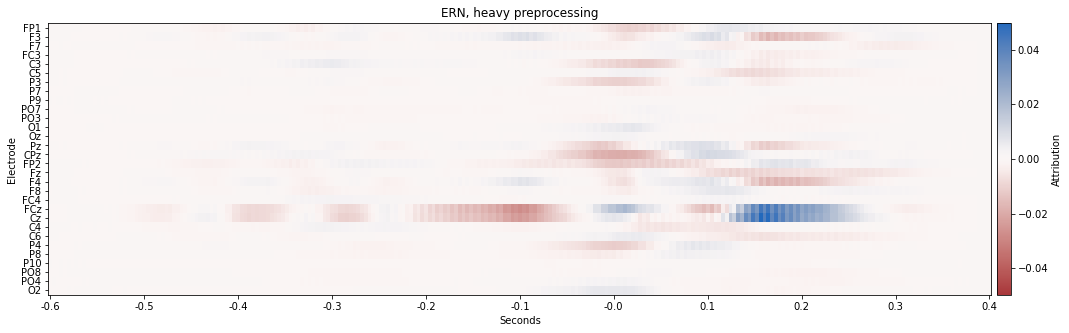

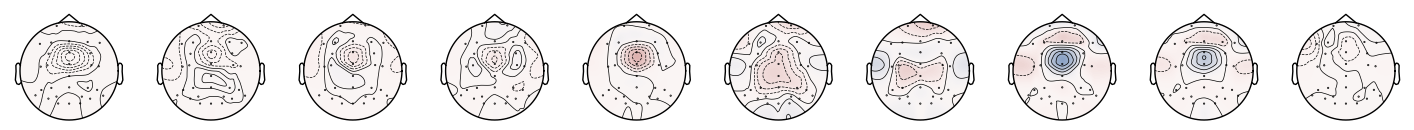

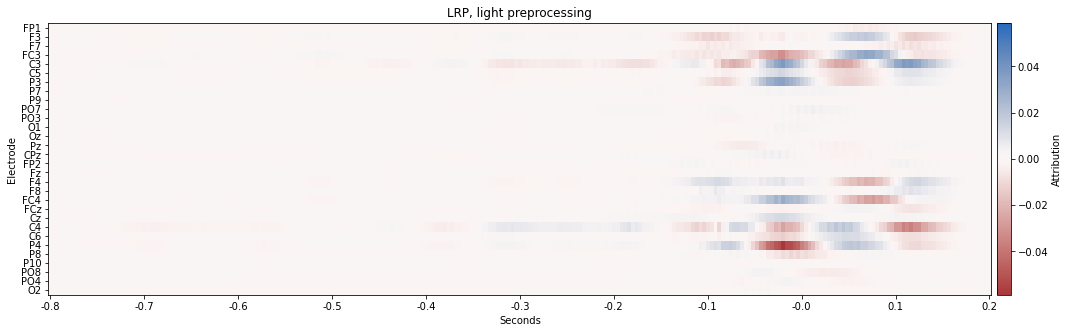

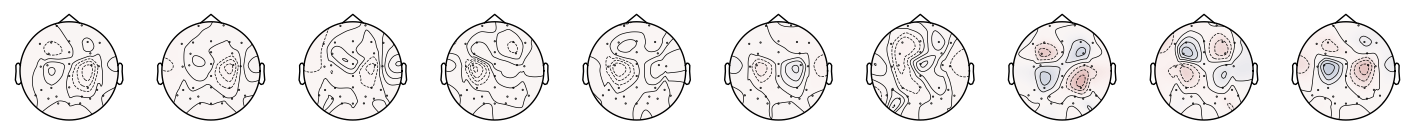

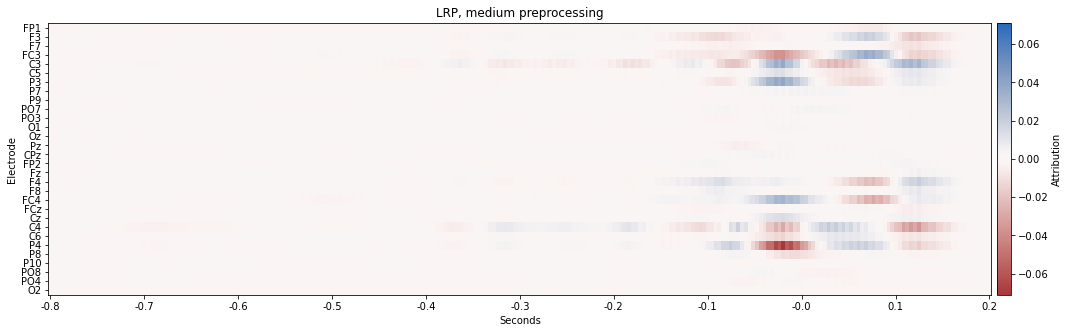

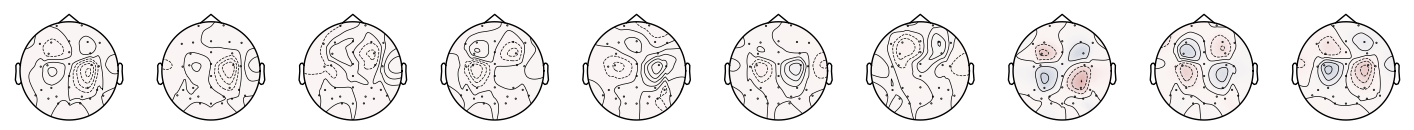

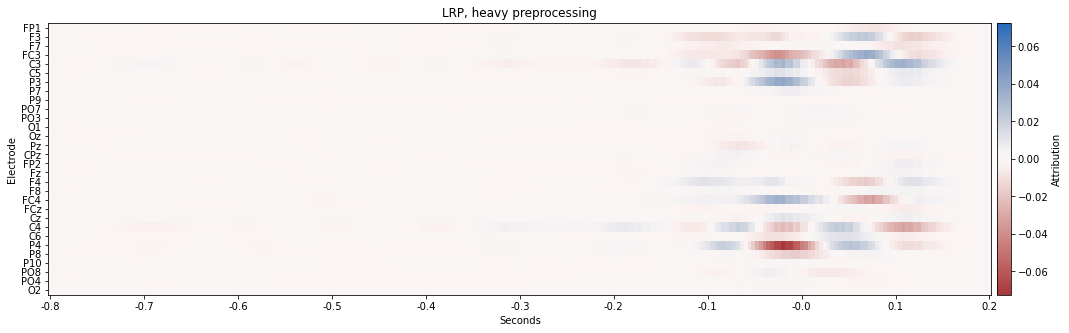

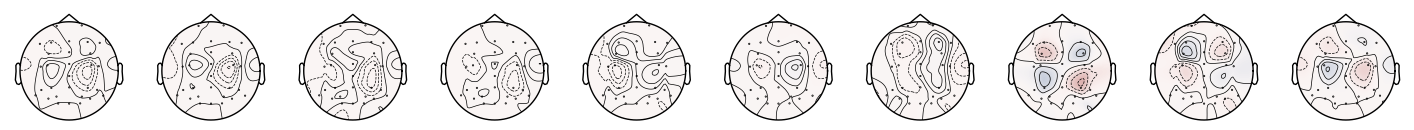

In [3]:
## P3 test 
data_path = "F:/Masterthesis/Data/"
model_name = "deep"
model_folder = "ModelComparison"
n_samples = 1000

for task in ["N170", "N400", "P3", "N2pc", "MMN", "ERN", "LRP"]:
    for preprocessing in ["light","medium","heavy"]:
        df = DataLoader.load_df(data_path, task, preprocessing)
        df = df.sample(n_samples, random_state=42)
        data, labels = DataLoader.create_data_labels(df)

        clf, model = Training.init_model(model_name, lr=0.01, gpu=False)
        model_path = os.getcwd()+"\\"+model_folder+"\\"+model_name+"\\"+task+"\\"+preprocessing+"\\"
        clf.load_params(f_params=model_path+"split_"+str(1)+"_model.pkl",
                               f_optimizer=model_path+"split_"+str(1)+"_optimizer.pkl",
                               f_history=model_path+"split_"+str(1)+"_history.json") 
        #data = data[np.where(clf.predict(data)==labels)[0]]

        dl = DeepLift(model)
        attribution = 0
        for i in range(len(data)):
            tensor = torch.from_numpy(data[i].reshape(1,30,251)).float()
            tensor.requires_grad = True
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                attribution += (dl.attribute(tensor, target=1)-dl.attribute(tensor, target=0))
                #attribution += abs(dl.attribute(tensor, target=0))
        attribution = attribution/n_samples
        plot_attribution(attribution, task, title=task+", "+preprocessing+ " preprocessing")
        plt.savefig("Plots/Preprocessing/"+task+"_"+preprocessing+"_attribution.png")
        plot_topo(attribution, task, timestamps=False)
        plt.savefig("Plots/Preprocessing/"+task+"_"+preprocessing+"_topo.png")

C:\Users\vapor\anaconda3\envs\braindecode\lib\site-packages\captum\_utils\gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
C:\Users\vapor\anaconda3\envs\braindecode\lib\site-packages\captum\attr\_core\deep_lift.py:322: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


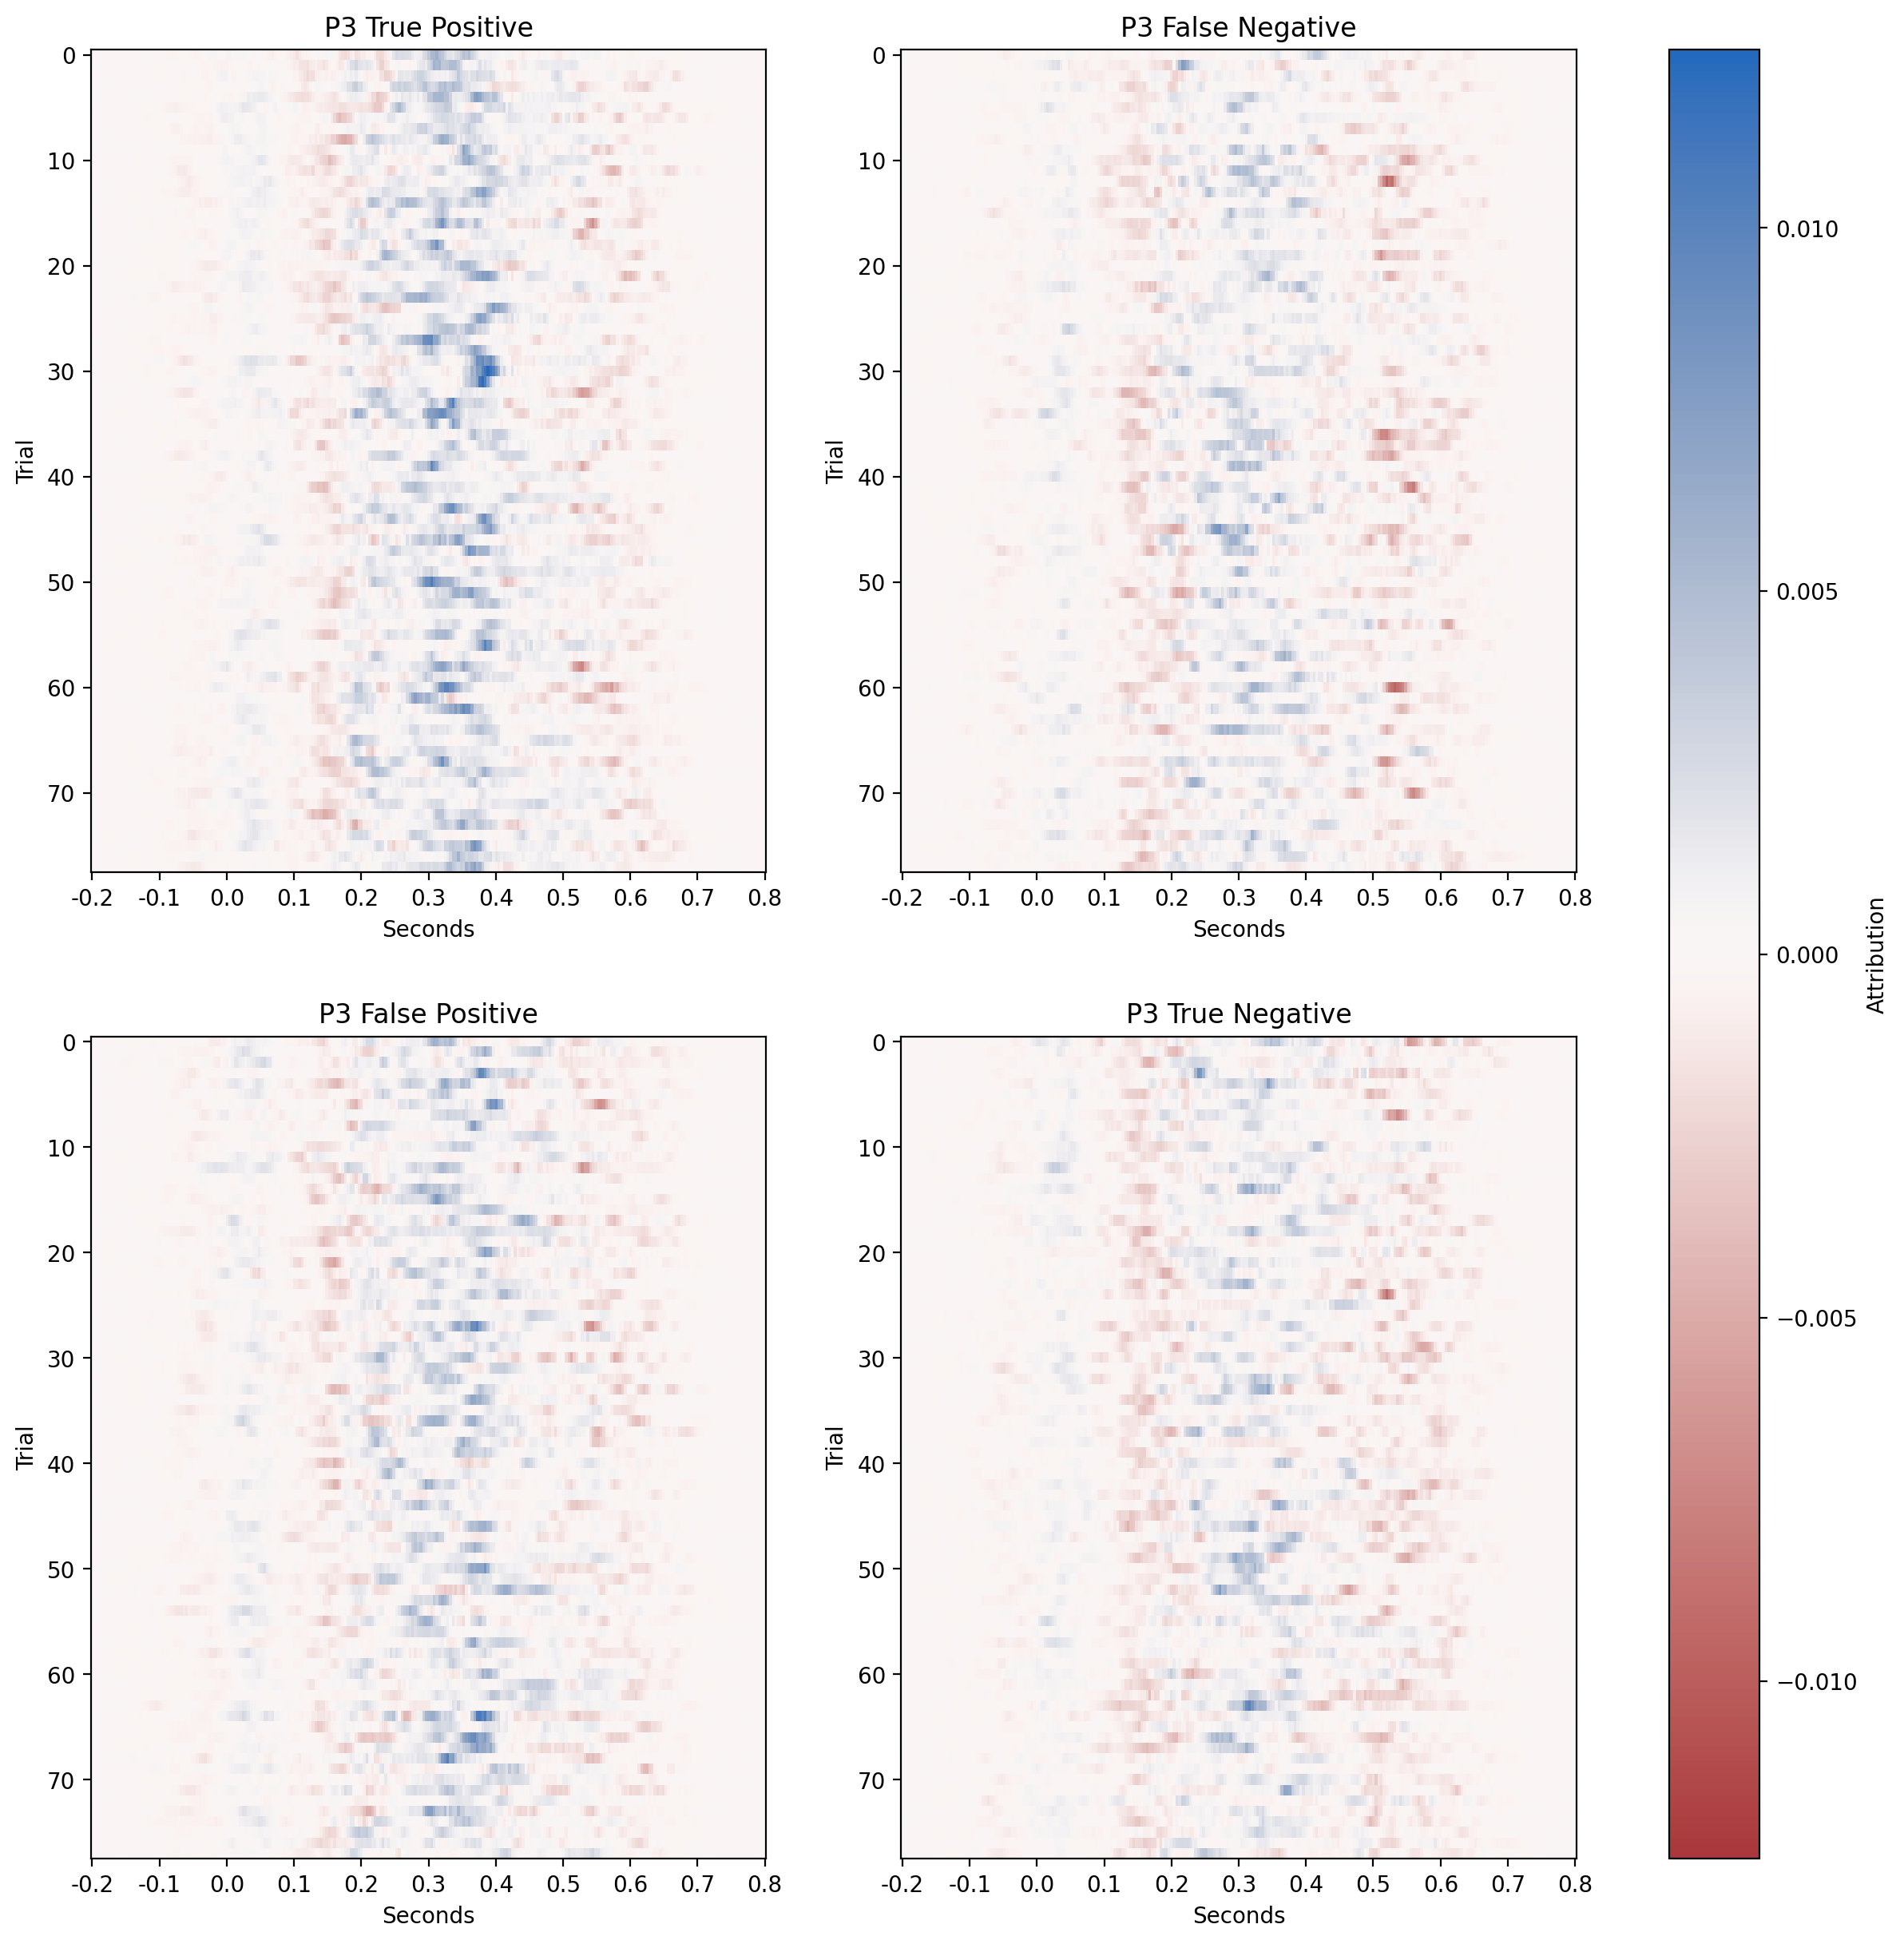

In [160]:
data_path = "F:/Masterthesis/Data/"
preprocessing = "heavy"
model_name = "deep"
model_folder = "ModelComparison"
task = "P3"


# load only validation data
df = DataLoader.load_df(data_path, task, preprocessing)
data, labels = DataLoader.create_data_labels(df)

cv = sklearn.model_selection.StratifiedShuffleSplit(10, test_size=0.2, random_state=42)
cv_split = cv.split(data,labels)
train_idx, test_idx = next(cv_split)
df = df.iloc[test_idx]

# load the datasets for tp, fp, tn, fn
df_cond_one = df[df["condition"]==1]
df_cond_zero = df[df["condition"]==0]

data_cond_one, labels_cond_one = DataLoader.create_data_labels(df_cond_one)
data_cond_zero, labels_cond_zero = DataLoader.create_data_labels(df_cond_zero)

# load model for predictions
clf, model = Training.init_model(model_name, lr=0.01, gpu=False)
model_path = os.getcwd()+"\\"+model_folder+"\\"+model_name+"\\"+task+"\\"+preprocessing+"\\"
clf.load_params(f_params=model_path+"split_"+str(1)+"_model.pkl",
                       f_optimizer=model_path+"split_"+str(1)+"_optimizer.pkl",
                       f_history=model_path+"split_"+str(1)+"_history.json")

data_tp = data_cond_one[np.where(clf.predict(data_cond_one)==labels_cond_one)[0]]
data_fn = data_cond_one[np.where(clf.predict(data_cond_one)!=labels_cond_one)[0]]
data_tn = data_cond_zero[np.where(clf.predict(data_cond_zero)==labels_cond_zero)[0]]
data_fp = data_cond_zero[np.where(clf.predict(data_cond_zero)!=labels_cond_zero)[0]]

# generate attribution maps
dl = DeepLift(model)
dict_data = {
    "tp": data_tp,
    "fp": data_fp,
    "tn": data_tn,
    "fn": data_fn
}
dict_attribution = {
    "tp": [],
    "fp": [],
    "tn": [],
    "fn": []
}
attr_min = 999
attr_max = -999
for xx in dict_data:
    for i in range(78):
        tensor = torch.from_numpy(dict_data[xx][i].reshape(1,30,251)).float()
        # append average attribution over all electrodes
        attr = (dl.attribute(tensor, target=1)).detach().numpy().mean(axis=1)-(dl.attribute(tensor, target=0)).detach().numpy().mean(axis=1)
        dict_attribution[xx].append(attr)
        attr_max = max(attr.max(), attr_max)
        attr_min = min(attr.min(), attr_min)
        
# plot attribution maps
sns.reset_orig()
fig, axes = plt.subplots(2, 2, figsize=(15, 15), dpi=200)
#color map is centered on zero and based on largest abs value
attr_abs = max(abs(attr_min),abs(attr_max))

axes[0,0].set_title(task+" True Positive")
im = axes[0,0].imshow(np.concatenate(dict_attribution["tp"], axis=0), aspect="auto",cmap="vlag_r", interpolation="none", vmin=-attr_abs, vmax=attr_abs)
axes[0,0].set_xticks(np.arange(0, 251, step=25))
axes[0,0].set_xticklabels(np.round(np.arange(-0.2, 0.81, step=0.1),2))
axes[0,0].set_xlabel("Seconds")
axes[0,0].set_ylabel("Trial")

axes[1,1].set_title(task+" True Negative")
axes[1,1].imshow(np.concatenate(dict_attribution["tn"], axis=0), aspect="auto",cmap="vlag_r", interpolation="none", vmin=-attr_abs, vmax=attr_abs)
axes[1,1].set_xticks(np.arange(0, 251, step=25))
axes[1,1].set_xticklabels(np.round(np.arange(-0.2, 0.81, step=0.1),2))
axes[1,1].set_xlabel("Seconds")
axes[1,1].set_ylabel("Trial")

axes[1,0].set_title(task+" False Positive")
axes[1,0].imshow(np.concatenate(dict_attribution["fp"], axis=0), aspect="auto",cmap="vlag_r", interpolation="none", vmin=-attr_abs, vmax=attr_abs)
axes[1,0].set_xticks(np.arange(0, 251, step=25))
axes[1,0].set_xticklabels(np.round(np.arange(-0.2, 0.81, step=0.1),2))
axes[1,0].set_xlabel("Seconds")
axes[1,0].set_ylabel("Trial")


axes[0,1].set_title(task+" False Negative")
axes[0,1].imshow(np.concatenate(dict_attribution["fn"], axis=0), aspect="auto",cmap="vlag_r", interpolation="none", vmin=-attr_abs, vmax=attr_abs)
axes[0,1].set_xticks(np.arange(0, 251, step=25))
axes[0,1].set_xticklabels(np.round(np.arange(-0.2, 0.81, step=0.1),2))
axes[0,1].set_xlabel("Seconds")
axes[0,1].set_ylabel("Trial")

fig.colorbar(im, ax=axes).set_label("Attribution")

C:\Users\vapor\anaconda3\envs\braindecode\lib\site-packages\captum\_utils\gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
C:\Users\vapor\anaconda3\envs\braindecode\lib\site-packages\captum\attr\_core\deep_lift.py:322: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


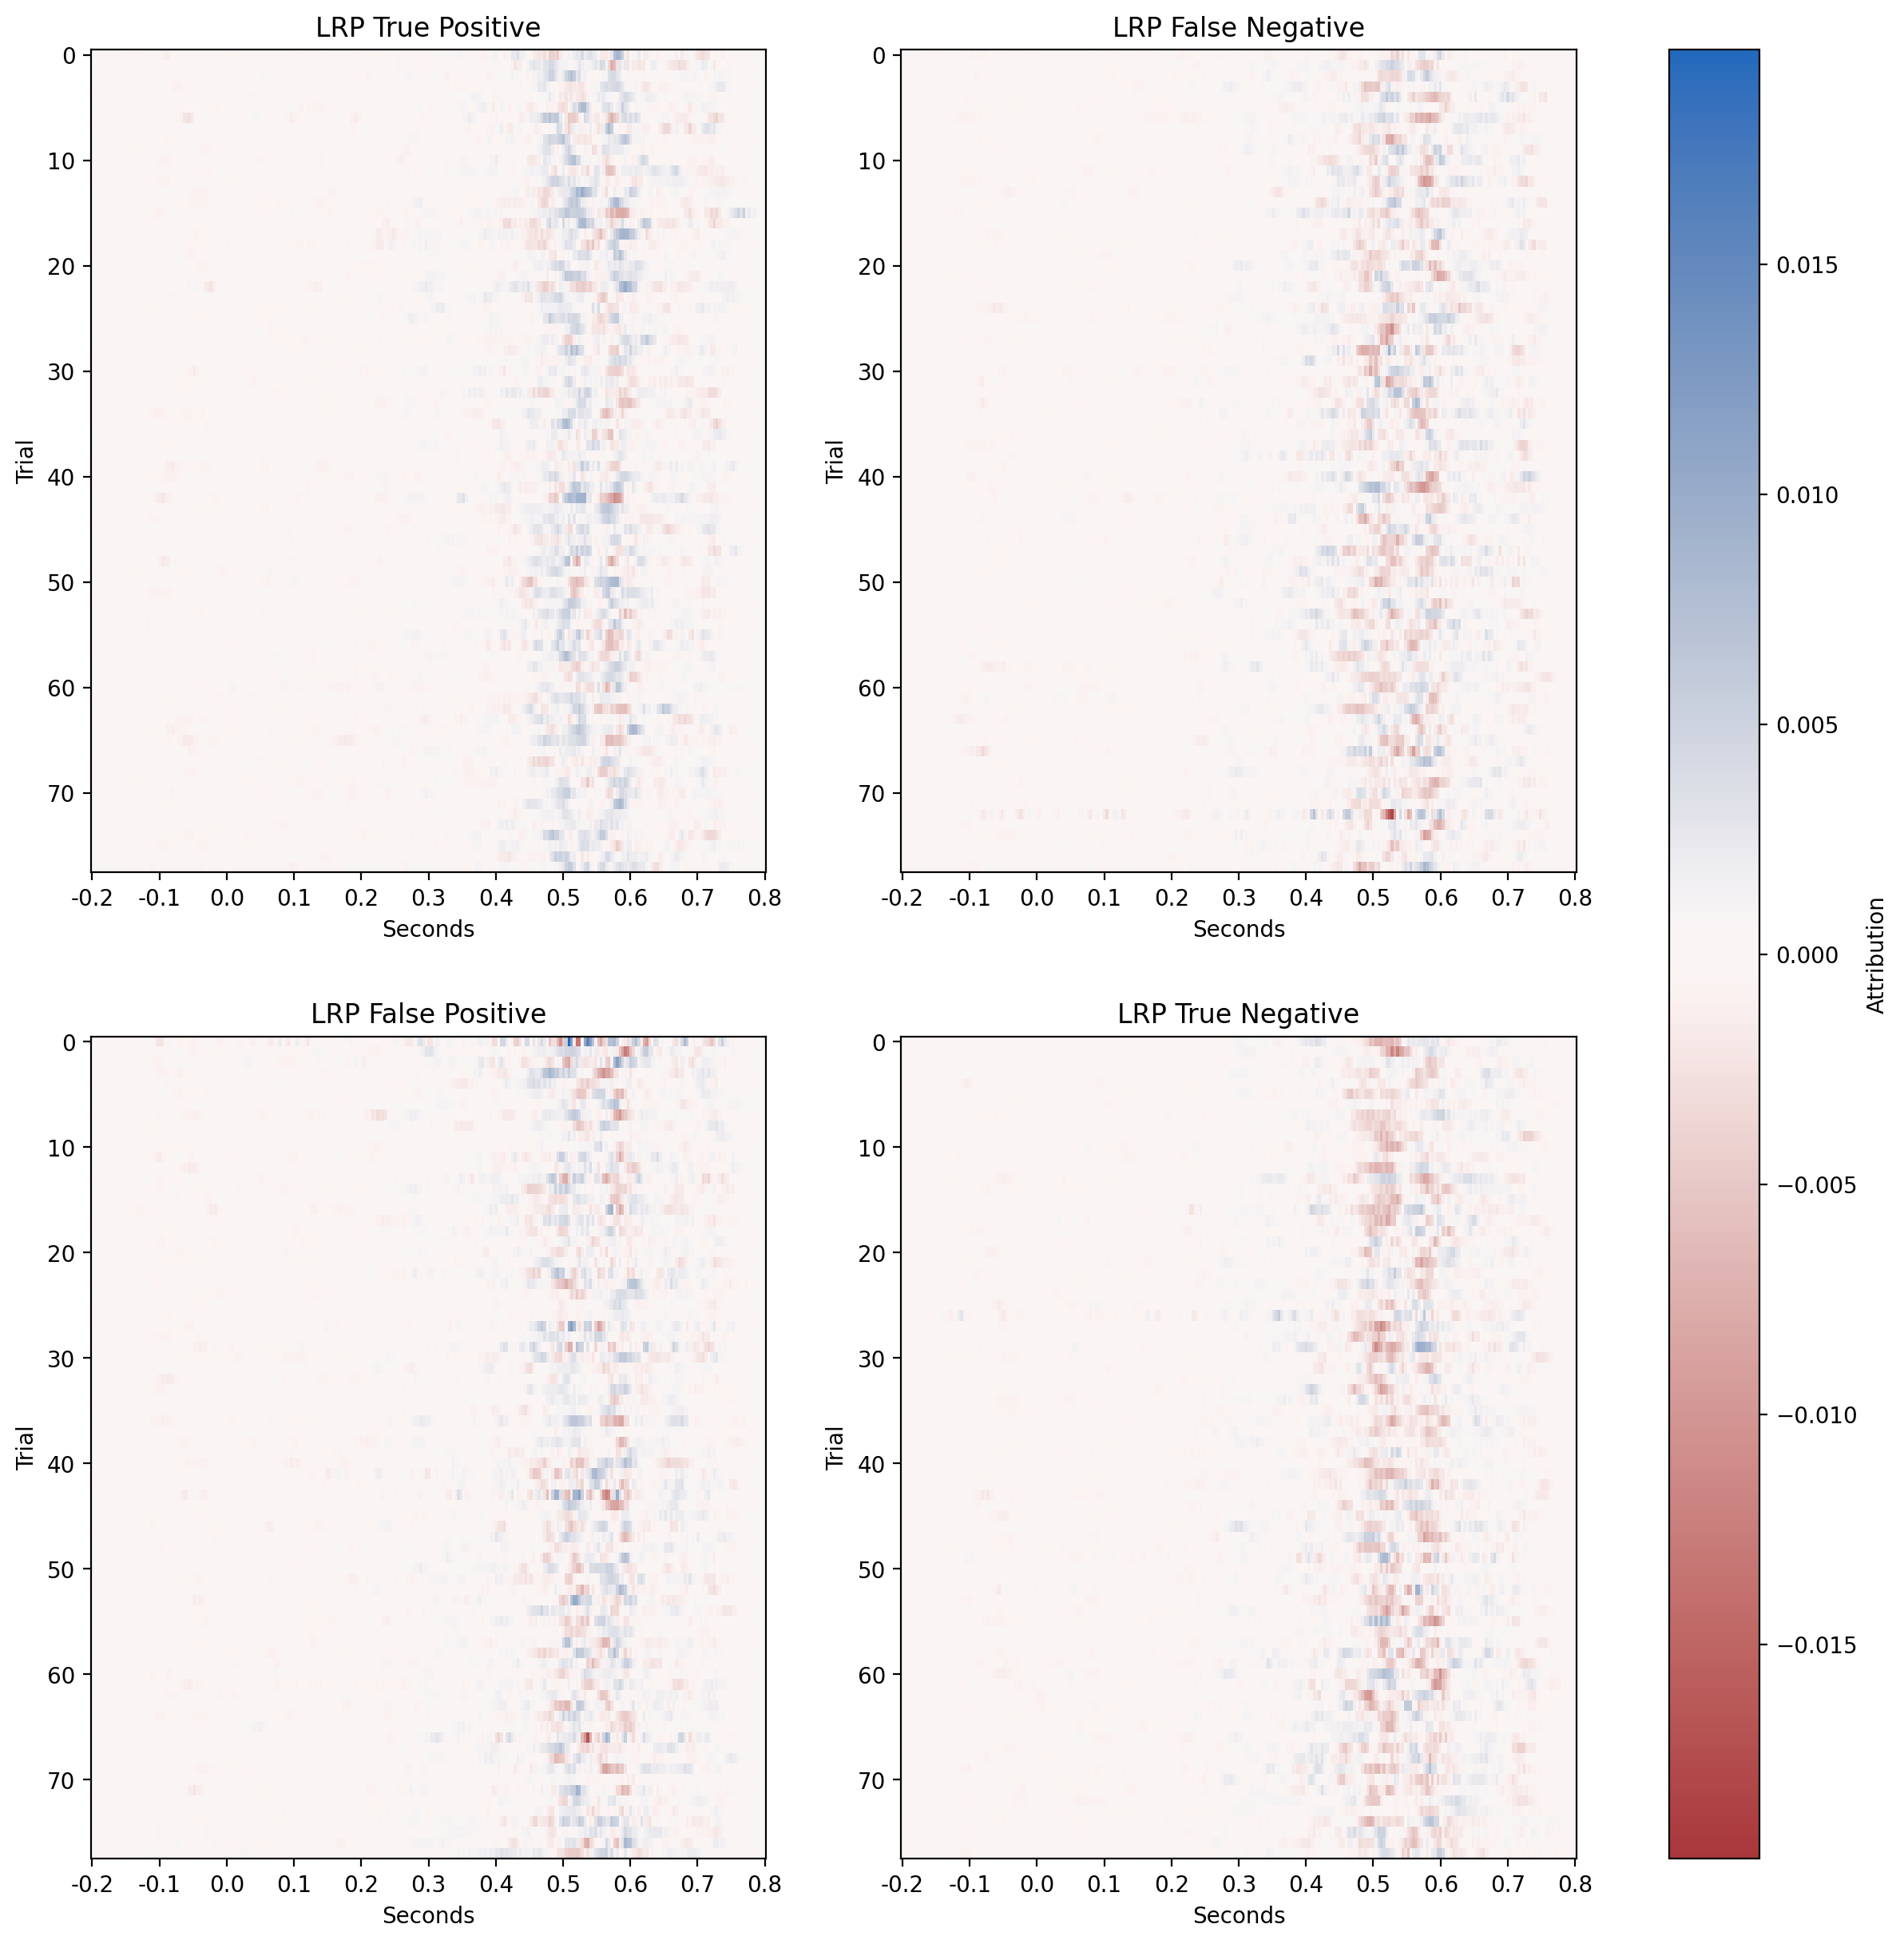

In [96]:
data_path = "F:/Masterthesis/Data/"
preprocessing = "medium"
model_name = "deep"
model_folder = "ModelComparison"
task = "LRP"


# load only validation data
df = DataLoader.load_df(data_path, task, preprocessing)
data, labels = DataLoader.create_data_labels(df)

cv = sklearn.model_selection.StratifiedShuffleSplit(10, test_size=0.2, random_state=42)
cv_split = cv.split(data,labels)
train_idx, test_idx = next(cv_split)
df = df.iloc[test_idx]

# load the datasets for tp, fp, tn, fn
df_cond_one = df[df["condition"]==1]
df_cond_zero = df[df["condition"]==0]

data_cond_one, labels_cond_one = DataLoader.create_data_labels(df_cond_one)
data_cond_zero, labels_cond_zero = DataLoader.create_data_labels(df_cond_zero)

# load model for predictions
clf, model = Training.init_model(model_name, lr=0.01, gpu=False)
model_path = os.getcwd()+"\\"+model_folder+"\\"+model_name+"\\"+task+"\\"+preprocessing+"\\"
clf.load_params(f_params=model_path+"split_"+str(1)+"_model.pkl",
                       f_optimizer=model_path+"split_"+str(1)+"_optimizer.pkl",
                       f_history=model_path+"split_"+str(1)+"_history.json")

data_tp = data_cond_one[np.where(clf.predict(data_cond_one)==labels_cond_one)[0]]
data_fn = data_cond_one[np.where(clf.predict(data_cond_one)!=labels_cond_one)[0]]
data_tn = data_cond_zero[np.where(clf.predict(data_cond_zero)==labels_cond_zero)[0]]
data_fp = data_cond_zero[np.where(clf.predict(data_cond_zero)!=labels_cond_zero)[0]]

# generate attribution maps
dl = DeepLift(model)
dict_data = {
    "tp": data_tp,
    "fp": data_fp,
    "tn": data_tn,
    "fn": data_fn
}
dict_attribution = {
    "tp": [],
    "fp": [],
    "tn": [],
    "fn": []
}
attr_min = 999
attr_max = -999
for xx in dict_data:
    for i in range(78):
        tensor = torch.from_numpy(dict_data[xx][i].reshape(1,30,251)).float()
        # append average attribution over all electrodes
        attr = (dl.attribute(tensor, target=1)).detach().numpy().mean(axis=1)-(dl.attribute(tensor, target=0)).detach().numpy().mean(axis=1)
        dict_attribution[xx].append(attr)
        attr_max = max(attr.max(), attr_max)
        attr_min = min(attr.min(), attr_min)
        
# plot attribution maps       
fig, axes = plt.subplots(2, 2, figsize=(15, 15), dpi=200)
sns.reset_orig()
#color map is centered on zero and based on largest abs value
attr_abs = max(abs(attr_min),abs(attr_max))

axes[0,0].set_title(task+" True Positive")
im = axes[0,0].imshow(np.concatenate(dict_attribution["tp"], axis=0), aspect="auto",cmap="vlag_r", interpolation="none", vmin=-attr_abs, vmax=attr_abs)
axes[0,0].set_xticks(np.arange(0, 251, step=25))
axes[0,0].set_xticklabels(np.round(np.arange(-0.2, 0.81, step=0.1),2))
axes[0,0].set_xlabel("Seconds")
axes[0,0].set_ylabel("Trial")

axes[1,1].set_title(task+" True Negative")
axes[1,1].imshow(np.concatenate(dict_attribution["tn"], axis=0), aspect="auto",cmap="vlag_r", interpolation="none", vmin=-attr_abs, vmax=attr_abs)
axes[1,1].set_xticks(np.arange(0, 251, step=25))
axes[1,1].set_xticklabels(np.round(np.arange(-0.2, 0.81, step=0.1),2))
axes[1,1].set_xlabel("Seconds")
axes[1,1].set_ylabel("Trial")

axes[1,0].set_title(task+" False Positive")
axes[1,0].imshow(np.concatenate(dict_attribution["fp"], axis=0), aspect="auto",cmap="vlag_r", interpolation="none", vmin=-attr_abs, vmax=attr_abs)
axes[1,0].set_xticks(np.arange(0, 251, step=25))
axes[1,0].set_xticklabels(np.round(np.arange(-0.2, 0.81, step=0.1),2))
axes[1,0].set_xlabel("Seconds")
axes[1,0].set_ylabel("Trial")


axes[0,1].set_title(task+" False Negative")
axes[0,1].imshow(np.concatenate(dict_attribution["fn"], axis=0), aspect="auto",cmap="vlag_r", interpolation="none", vmin=-attr_abs, vmax=attr_abs)
axes[0,1].set_xticks(np.arange(0, 251, step=25))
axes[0,1].set_xticklabels(np.round(np.arange(-0.2, 0.81, step=0.1),2))
axes[0,1].set_xlabel("Seconds")
axes[0,1].set_ylabel("Trial")

fig.colorbar(im, ax=axes).set_label("Attribution")

In [2]:
def plot_attribution_vs_erp(data_tp, data_tn, attribution, title=None, pick=None, move_y=0):
    #sns.set(style="darkgrid")
    if pick == None:
        t = attribution.detach().numpy().mean(axis=1).flatten()
        y = data_tp.mean(axis=0).mean(axis=0)-data_tn.mean(axis=0).mean(axis=0)
        #y = data_tn.mean(axis=0).mean(axis=0)#-data_tn.mean(axis=0).mean(axis=0)
    else:
        channels = ['FP1','F3','F7','FC3','C3','C5','P3','P7','P9','PO7',
                    'PO3','O1','Oz','Pz','CPz','FP2','Fz','F4','F8','FC4',
                    'FCz','Cz','C4','C6','P4','P8','P10','PO8','PO4','O2',]
        pickID = channels.index(pick)
        t = attribution.detach().numpy()[:,pickID:pickID+1,:].mean(axis=1).flatten()
        y = data_tp[:,pickID,:].mean(axis=0)-data_tn[:,pickID,:].mean(axis=0)+move_y
    fig, ax1 = plt.subplots(figsize=(10, 3))
    if title != None:
        fig.suptitle(title)

    color = 'tab:blue'
    ax1.set_xlabel('Seconds')
    ax1.set_ylabel('Difference Wave ('+u"\u03bcV)", color=color)
    ax1.plot(y, color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.set_xticks(np.arange(0, 251, step=25))
    if task == "LRP":
        ax1.set_xticklabels(np.round(np.arange(-0.8, 0.21, step=0.1),2))
    elif task == "ERN":
        ax1.set_xticklabels(np.round(np.arange(-0.6, 0.41, step=0.1),2))
    else:
        ax1.set_xticklabels(np.round(np.arange(-0.2, 0.81, step=0.1),2))

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:red'
    ax2.set_ylabel('Attribution', color=color)  # we already handled the x-label with ax1
    ax2.plot(t, color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.set_xticks(np.arange(0, 251, step=25))
    if task == "LRP":
        ax1.set_xticklabels(np.round(np.arange(-0.8, 0.21, step=0.1),2))
    elif task == "ERN":
        ax1.set_xticklabels(np.round(np.arange(-0.6, 0.41, step=0.1),2))
    else:
        ax1.set_xticklabels(np.round(np.arange(-0.2, 0.81, step=0.1),2))

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    yabs_max1 = abs(max(ax1.get_ylim(), key=abs))
    ax1.set_ylim(ymin=-yabs_max1, ymax=yabs_max1)
    #yabs_max1 = int(yabs_max1)
    #ax1.set_yticks(np.arange(-yabs_max1, yabs_max1, step=yabs_max1/2))
    #ax1.set_yticklabels(np.arange(-yabs_max1-move_y, yabs_max1-move_y, step=yabs_max1/2))
    
    yabs_max2 = abs(max(ax2.get_ylim(), key=abs))
    ax2.set_ylim(ymin=-yabs_max2, ymax=yabs_max2)
    
    plt.show()

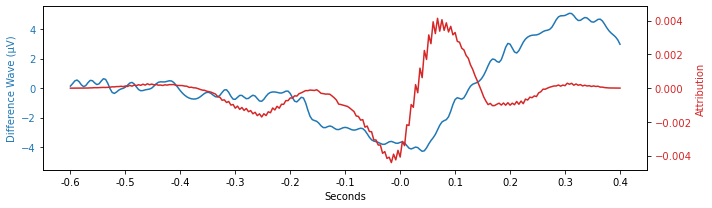

In [6]:
data_path = "F:/Masterthesis/Data/"
preprocessing = "heavy"
model_name = "deep"
model_folder = "ModelComparison"
task = "ERN"


# load only validation data
df = DataLoader.load_df(data_path, task, preprocessing)
data, labels = DataLoader.create_data_labels(df)

cv = sklearn.model_selection.StratifiedShuffleSplit(10, test_size=0.2, random_state=42)
cv_split = cv.split(data,labels)
train_idx, test_idx = next(cv_split)
df = df.iloc[test_idx]

# load the datasets for tp, fp, tn, fn
df_cond_one = df[df["condition"]==1]
df_cond_zero = df[df["condition"]==0]

data_cond_one, labels_cond_one = DataLoader.create_data_labels(df_cond_one)
data_cond_zero, labels_cond_zero = DataLoader.create_data_labels(df_cond_zero)

# load model for predictions
clf, model = Training.init_model(model_name, lr=0.01, gpu=False)
model_path = os.getcwd()+"\\"+model_folder+"\\"+model_name+"\\"+task+"\\"+preprocessing+"\\"
clf.load_params(f_params=model_path+"split_"+str(1)+"_model.pkl",
                       f_optimizer=model_path+"split_"+str(1)+"_optimizer.pkl",
                       f_history=model_path+"split_"+str(1)+"_history.json")

data_tp = data_cond_one[np.where(clf.predict(data_cond_one)==labels_cond_one)[0]]
data_fn = data_cond_one[np.where(clf.predict(data_cond_one)!=labels_cond_one)[0]]
data_tn = data_cond_zero[np.where(clf.predict(data_cond_zero)==labels_cond_zero)[0]]
data_fp = data_cond_zero[np.where(clf.predict(data_cond_zero)!=labels_cond_zero)[0]]

dl = DeepLift(model)
attribution = 0
for i in range(len(data_tp)):
    tensor = torch.from_numpy(data_tp[i].reshape(1,30,251)).float()
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        attribution += dl.attribute(tensor, target=1)-dl.attribute(tensor, target=0)
for i in range(len(data_tn)):
    tensor = torch.from_numpy(data_tn[i].reshape(1,30,251)).float()
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        attribution += dl.attribute(tensor, target=1)-dl.attribute(tensor, target=0)
attribution = attribution/(len(data_tp)+len(data_tn))

        
plot_attribution_vs_erp(data_tp, data_tn, attribution, pick="P8")

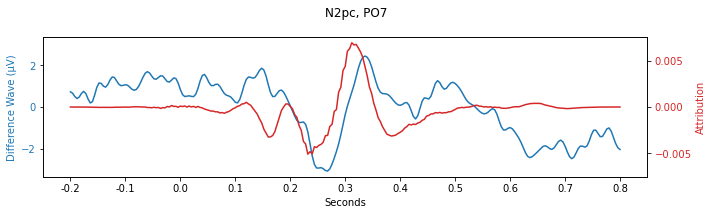

In [4]:
pick = "PO7"
plot_attribution_vs_erp(data_tp, data_tn, attribution, pick=pick, title=task+", "+pick)

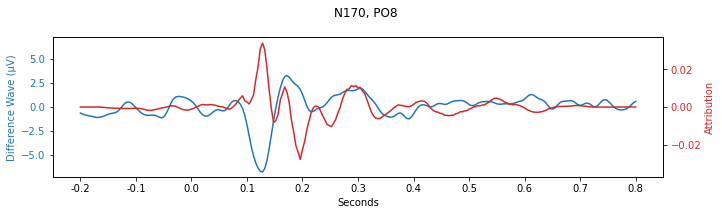

In [123]:
pick = "PO8"
plot_attribution_vs_erp(data_tp, data_tn, attribution, pick=pick, title=task+", "+pick)

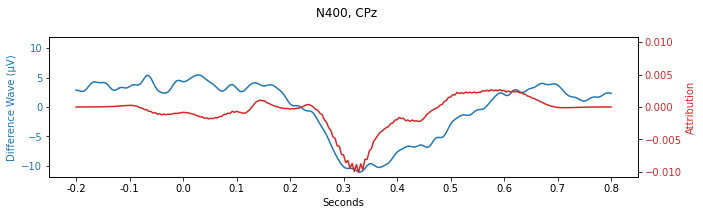

In [179]:
pick = "CPz"
plot_attribution_vs_erp(data_tp, data_tn, attribution, pick=pick, title=task+", "+pick)

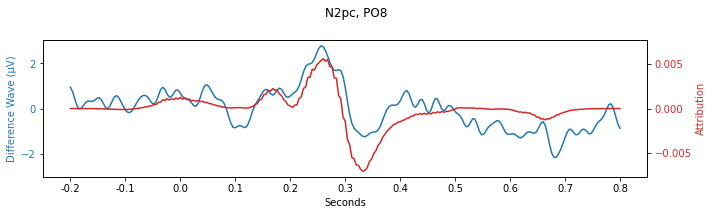

In [183]:
pick = "PO8"
plot_attribution_vs_erp(data_tp, data_tn, attribution, pick=pick, title=task+", "+pick)

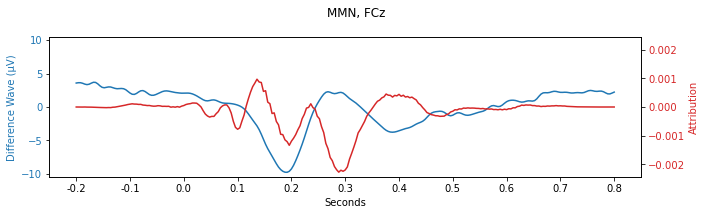

In [181]:
pick = "FCz"
plot_attribution_vs_erp(data_tp, data_tn, attribution, pick=pick, title=task+", "+pick)

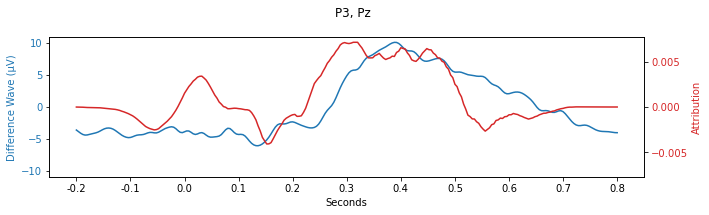

In [185]:
pick = "Pz"
plot_attribution_vs_erp(data_tp, data_tn, attribution, pick=pick, title=task+", "+pick)

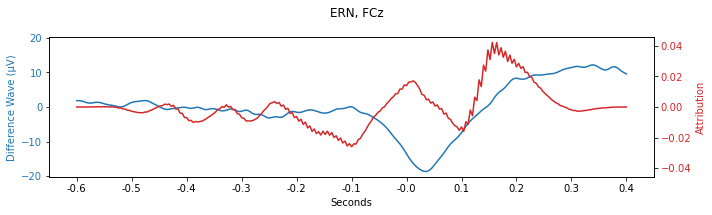

In [7]:
pick = "FCz"
plot_attribution_vs_erp(data_tp, data_tn, attribution, pick=pick, title=task+", "+pick)

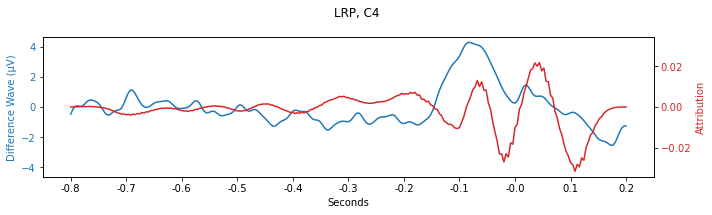

In [4]:
pick = "C4"
plot_attribution_vs_erp(data_tp, data_tn, attribution, pick=pick, title=task+", "+pick)

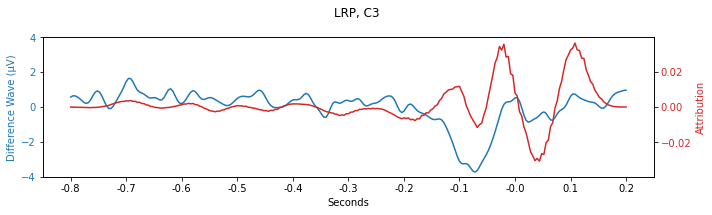

In [5]:
pick = "C3"
plot_attribution_vs_erp(data_tp, data_tn, attribution, pick=pick, title=task+", "+pick)

In [106]:
from matplotlib.lines import Line2D

def plot_attribution_lines(data, attribution, data2, attribution2, title=None, pick=None, legend=False):
    #sns.set(style="darkgrid")
    
    if pick == None:
        t = attribution.detach().numpy().mean(axis=1).flatten()
        t2 = attribution2.detach().numpy().mean(axis=1).flatten()
        y = data.mean(axis=0).mean(axis=0)
        y2 = data2.mean(axis=0).mean(axis=0)

    else:
        channels = ['FP1','F3','F7','FC3','C3','C5','P3','P7','P9','PO7',
                    'PO3','O1','Oz','Pz','CPz','FP2','Fz','F4','F8','FC4',
                    'FCz','Cz','C4','C6','P4','P8','P10','PO8','PO4','O2',]
        pickID = channels.index(pick)
        t = attribution.detach().numpy()[:,pickID:pickID+1,:].mean(axis=1).flatten()
        t2 = attribution2.detach().numpy()[:,pickID:pickID+1,:].mean(axis=1).flatten()
        y = data[:,pickID,:].mean(axis=0)
        y2 = data2[:,pickID,:].mean(axis=0)
    
    if task == "LRP":
        x = np.linspace(-800, 200, 251)
    elif task == "ERN":
        x = np.linspace(-600, 400, 251)
    else:
        x = np.linspace(-200, 800, 251)
    
    #c = (t - np.min(t))/np.ptp(t)
    #c2 = (t2 - np.min(t2))/np.ptp(t2)
    # dont normalize attribution
    c=t
    c2=t2
    vabs=abs(max(c.min(), c.max(), c2.min(), c2.max(), key=abs))
    
    # adapted from https://matplotlib.org/3.1.1/gallery/
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    
    points2 = np.array([x, y2]).T.reshape(-1, 1, 2)
    segments2 = np.concatenate([points2[:-1], points2[1:]], axis=1) 
    
    fig, axs = plt.subplots(1, 1, figsize=(15, 5), dpi=100)
    # Create a continuous norm to map from data points to colors
    #norm = plt.Normalize(c.min(), c.max())
    lc = LineCollection(segments, cmap='vlag_r')
    lc.set_clim(vmin=-vabs, vmax=vabs)
    # Set the values used for colormapping
    lc.set_array(c)
    lc.set_linewidth(2)
    line = axs.add_collection(lc)
    
    #norm2 = plt.Normalize(c2.min(), c2.max())
    lc2 = LineCollection(segments2, cmap='vlag_r')
    lc2.set_dashes(':')
    lc2.set_clim(vmin=-vabs, vmax=vabs)
    # Set the values used for colormapping
    lc2.set_array(c2)
    lc2.set_linewidth(2)
    line2 = axs.add_collection(lc2)  
    
    fig.colorbar(line, ax=axs) 
    
    axs.set_ylabel(u"\u03bcV")
    axs.set_xlabel('Milliseconds')
    axs.set_xlim(x.min(), x.max())
    axs.set_ylim(min(y.min(),y2.min())*1.1, max(y.max(),y2.max())*1.1)
    if title != None:
        plt.title(title)
    if legend:
        legend = [Line2D([0], [0], linewidth=3), Line2D([0], [0], linewidth=3, linestyle=':')]
        labels = ['True Positive', 'True Negative']
        plt.legend(legend, labels, loc='lower right')
        

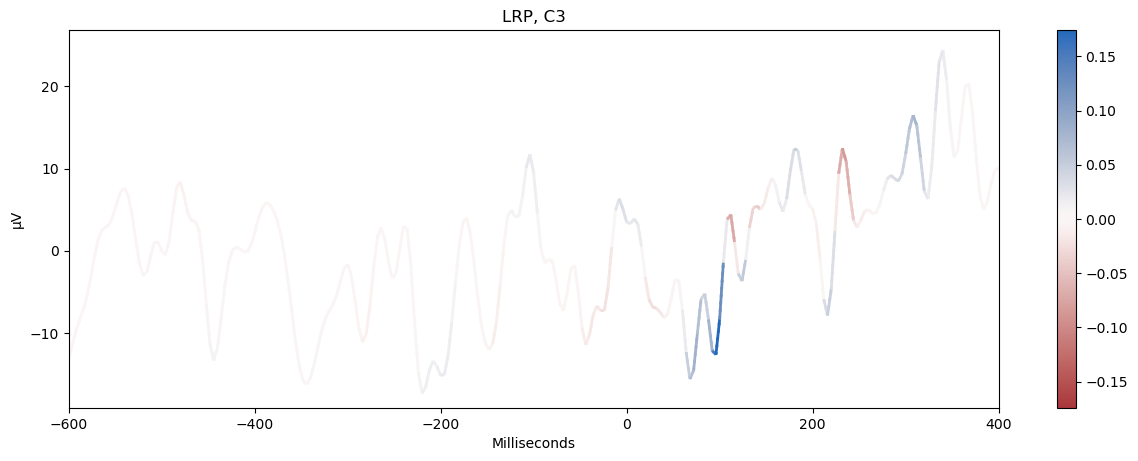

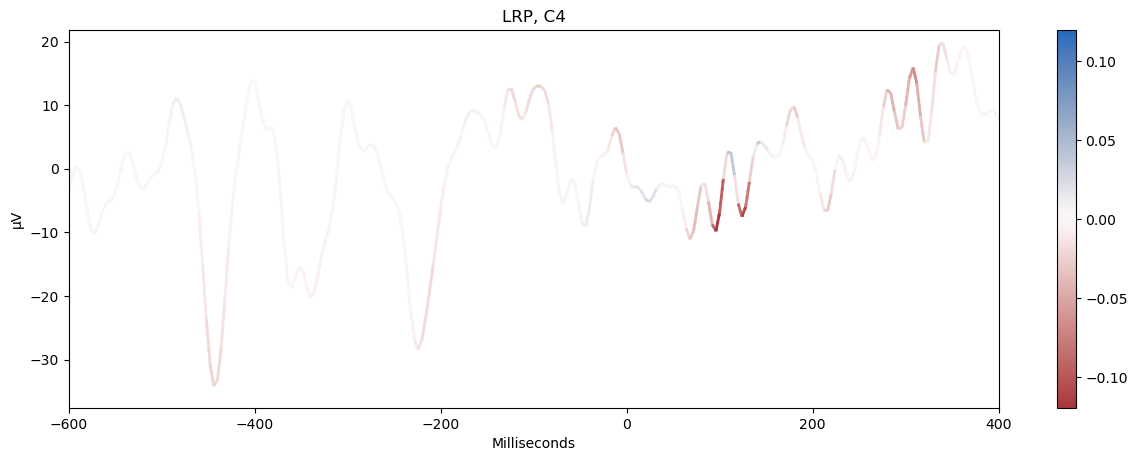

In [81]:
data_path = "F:/Masterthesis/Data/"
preprocessing = "heavy"
model_name = "deep"
model_folder = "ModelComparison"
task = "LRP"


# load only validation data
df = DataLoader.load_df(data_path, task, preprocessing)
data, labels = DataLoader.create_data_labels(df)

cv = sklearn.model_selection.StratifiedShuffleSplit(10, test_size=0.2, random_state=42)
cv_split = cv.split(data,labels)
train_idx, test_idx = next(cv_split)
df = df.iloc[test_idx]

# load the datasets for tp, fp, tn, fn
df_cond_one = df[df["condition"]==1]
df_cond_zero = df[df["condition"]==0]

data_cond_one, labels_cond_one = DataLoader.create_data_labels(df_cond_one)
data_cond_zero, labels_cond_zero = DataLoader.create_data_labels(df_cond_zero)

# load model for predictions
clf, model = Training.init_model(model_name, lr=0.01, gpu=False)
model_path = os.getcwd()+"\\"+model_folder+"\\"+model_name+"\\"+task+"\\"+preprocessing+"\\"
clf.load_params(f_params=model_path+"split_"+str(1)+"_model.pkl",
                       f_optimizer=model_path+"split_"+str(1)+"_optimizer.pkl",
                       f_history=model_path+"split_"+str(1)+"_history.json")

p=2
data_tp = data_cond_one[np.where(clf.predict(data_cond_one)==labels_cond_one)[0]][p:p+1]
data_fn = data_cond_one[np.where(clf.predict(data_cond_one)!=labels_cond_one)[0]][p:p+1]
data_tn = data_cond_zero[np.where(clf.predict(data_cond_zero)==labels_cond_zero)[0]][p:p+1]
data_fp = data_cond_zero[np.where(clf.predict(data_cond_zero)!=labels_cond_zero)[0]][p:p+1]

dl = DeepLift(model)
attribution_tp = 0
for i in range(len(data_tp)):
    tensor = torch.from_numpy(data_tp[i].reshape(1,30,251)).float()
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        attribution_tp += dl.attribute(tensor, target=1)-dl.attribute(tensor, target=0)
attribution_tp = attribution_tp/len(data_tp)

dl = DeepLift(model)
attribution_tn = 0
for i in range(len(data_tn)):
    tensor = torch.from_numpy(data_tn[i].reshape(1,30,251)).float()
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        attribution_tn += dl.attribute(tensor, target=1)-dl.attribute(tensor, target=0)
attribution_tn = attribution_tn/len(data_tn)

pick = "C3"
plot_attribution_lines(data_tp, attribution_tp, data_tp, attribution_tp, title=task+", "+pick, pick=pick)
pick = "C4"
plot_attribution_lines(data_tp, attribution_tp, data_tp, attribution_tp, title=task+", "+pick, pick=pick)

In [82]:
data_path = "F:/Masterthesis/Data/"
preprocessing = "heavy"
model_name = "deep"
model_folder = "ModelComparison"
task = "LRP"


# load only validation data
df = DataLoader.load_df(data_path, task, preprocessing)
data, labels = DataLoader.create_data_labels(df)

cv = sklearn.model_selection.StratifiedShuffleSplit(10, test_size=0.2, random_state=42)
cv_split = cv.split(data,labels)
train_idx, test_idx = next(cv_split)
df = df.iloc[test_idx]

# load the datasets for tp, fp, tn, fn
df_cond_one = df[df["condition"]==1]
df_cond_zero = df[df["condition"]==0]

data_cond_one, labels_cond_one = DataLoader.create_data_labels(df_cond_one)
data_cond_zero, labels_cond_zero = DataLoader.create_data_labels(df_cond_zero)

# load model for predictions
clf, model = Training.init_model(model_name, lr=0.01, gpu=False)
model_path = os.getcwd()+"\\"+model_folder+"\\"+model_name+"\\"+task+"\\"+preprocessing+"\\"
clf.load_params(f_params=model_path+"split_"+str(1)+"_model.pkl",
                       f_optimizer=model_path+"split_"+str(1)+"_optimizer.pkl",
                       f_history=model_path+"split_"+str(1)+"_history.json")

data_tp = data_cond_one[np.where(clf.predict(data_cond_one)==labels_cond_one)[0]]
data_fn = data_cond_one[np.where(clf.predict(data_cond_one)!=labels_cond_one)[0]]
data_tn = data_cond_zero[np.where(clf.predict(data_cond_zero)==labels_cond_zero)[0]]
data_fp = data_cond_zero[np.where(clf.predict(data_cond_zero)!=labels_cond_zero)[0]]

dl = DeepLift(model)
attribution_tp = 0
for i in range(len(data_tp)):
    tensor = torch.from_numpy(data_tp[i].reshape(1,30,251)).float()
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        attribution_tp += dl.attribute(tensor, target=1)-dl.attribute(tensor, target=0)
attribution_tp = attribution_tp/len(data_tp)

dl = DeepLift(model)
attribution_tn = 0
for i in range(len(data_tn)):
    tensor = torch.from_numpy(data_tn[i].reshape(1,30,251)).float()
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        attribution_tn += dl.attribute(tensor, target=1)-dl.attribute(tensor, target=0)
attribution_tn = attribution_tn/len(data_tn)

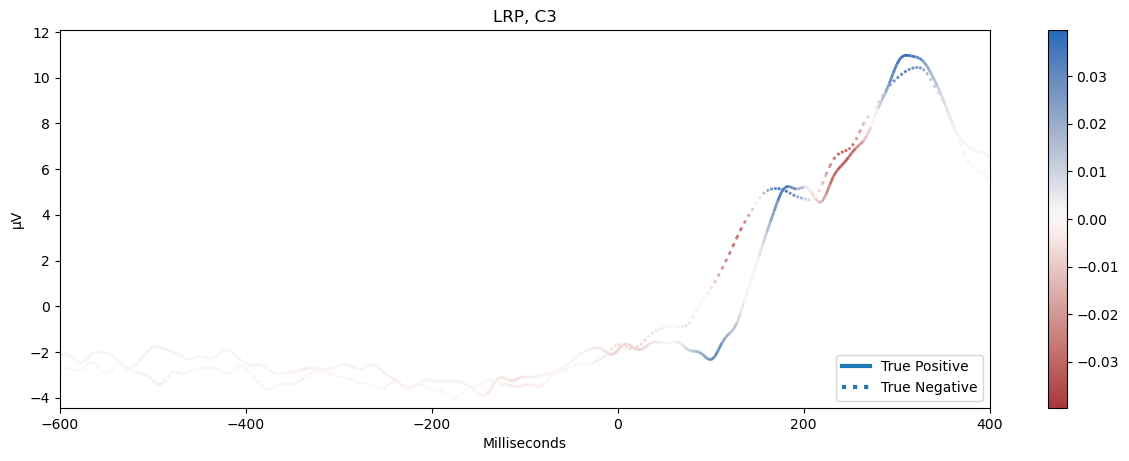

In [107]:
pick = "C3"
plot_attribution_lines(data_tp, attribution_tp, data_tn, attribution_tn, title=task+", "+pick, pick=pick, legend=True)

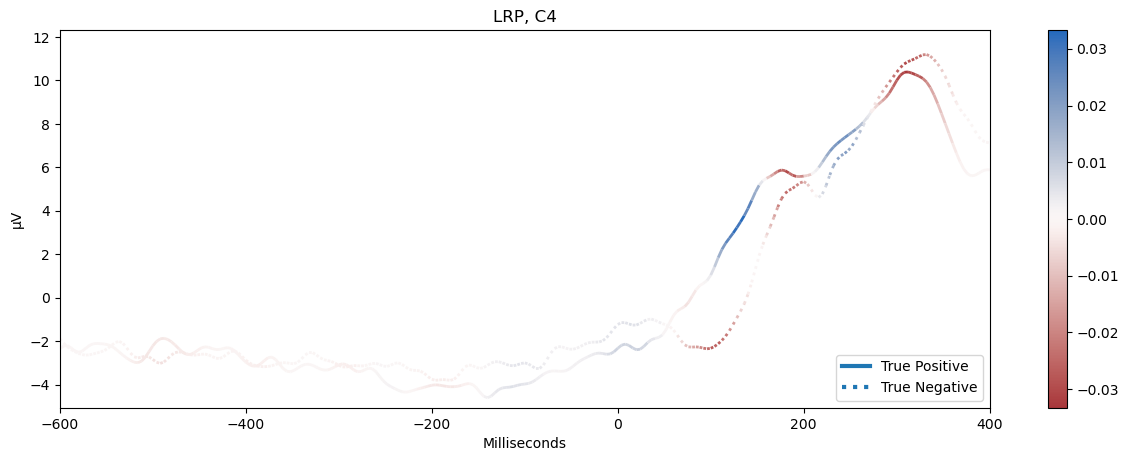

In [110]:
pick = "C4"
plot_attribution_lines(data_tp, attribution_tp, data_tn, attribution_tn, title=task+", "+pick, pick=pick, legend=True)

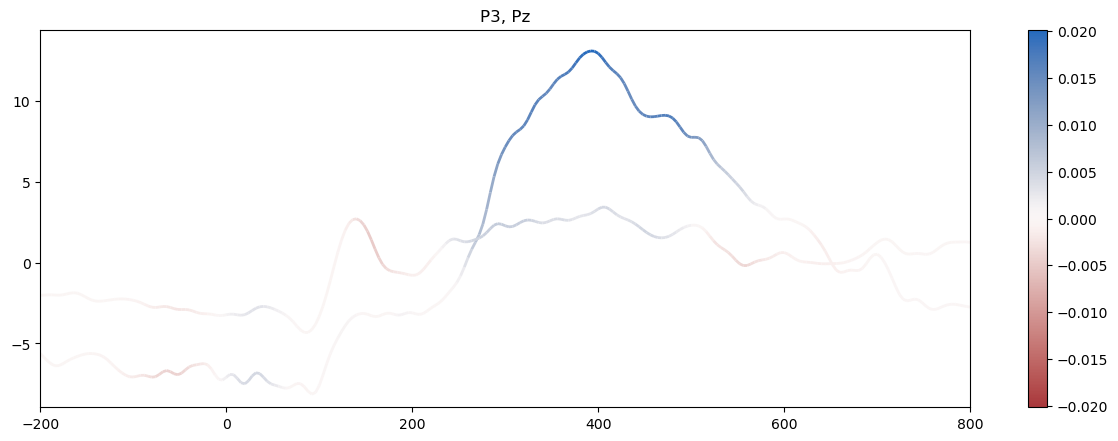

In [168]:
pick = "Pz"
plot_attribution_lines(data_tp, attribution_tp, data_tn, attribution_tn, title=task+", "+pick, pick=pick,  legend=True)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 

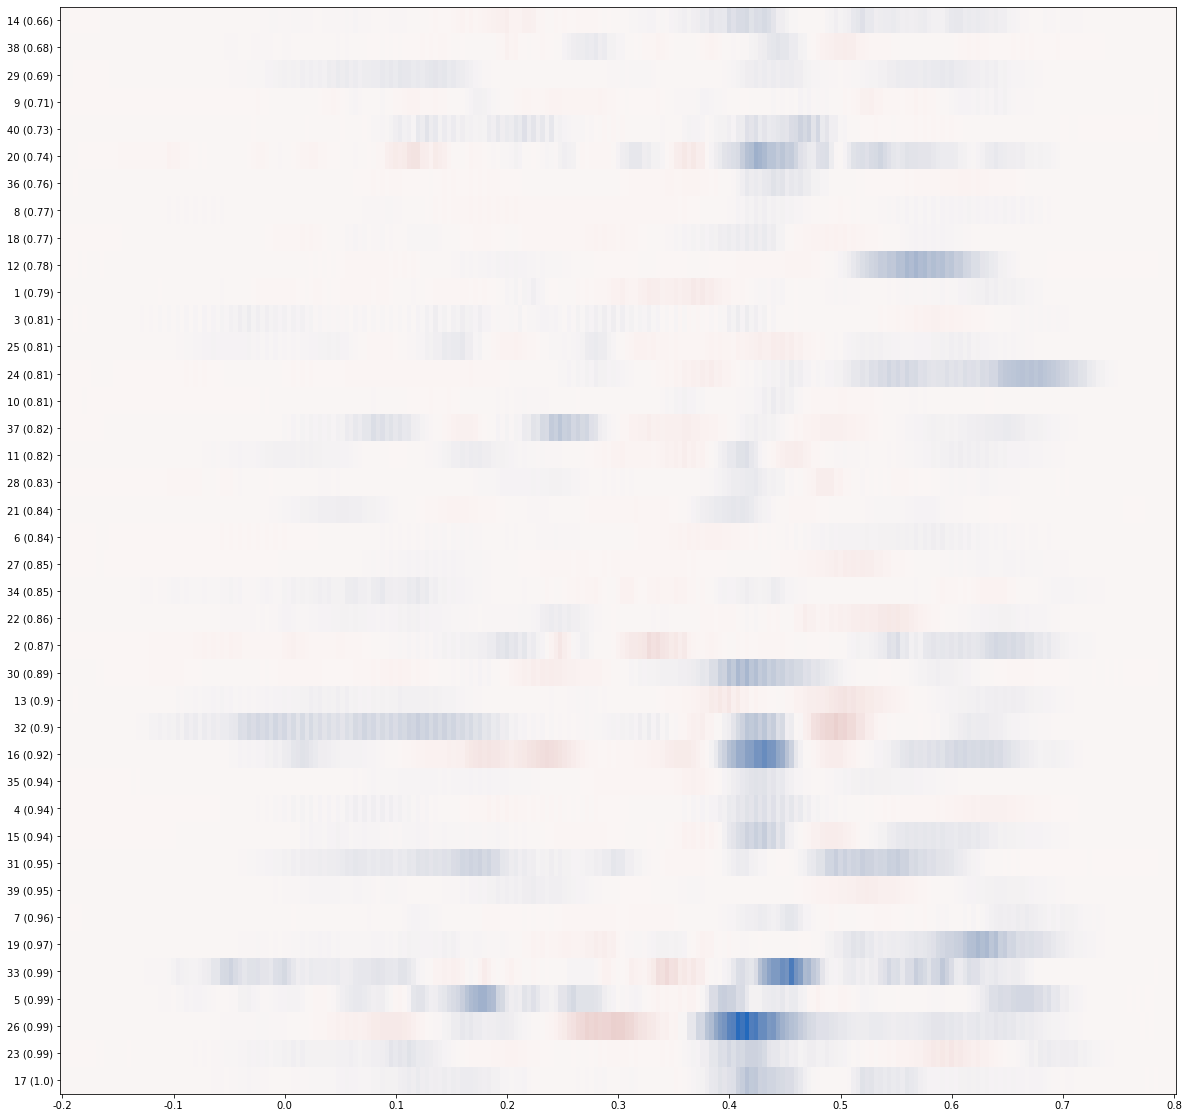

In [64]:
data_path = "F:/Masterthesis/Data/"
preprocessing = "medium"
model_name = "deep"
model_folder = "SubjectAnalysis_Within"
task = "ERN"
split = 2

df = DataLoader.load_df(data_path, task, preprocessing)

attribution = []
for subjectID in range(40): 
    df_cond_one = df[(df["condition"]==1) & (df["subjectID"]==subjectID)]
    data_cond_one, labels_cond_one = DataLoader.create_data_labels(df_cond_one)

    # load model for predictions
    clf, model = Training.init_model(model_name, lr=0.01, gpu=False)
    model_path = os.getcwd()+"\\"+model_folder+"\\"+model_name+"\\"+task+"\\"+preprocessing+"\\"
    clf.load_params(f_params=model_path+"subject_"+str(subjectID)+"_split_"+str(split)+"_model.pkl",
                           f_optimizer=model_path+"subject_"+str(subjectID)+"_split_"+str(split)+"_optimizer.pkl",
                           f_history=model_path+"subject_"+str(subjectID)+"_split_"+str(split)+"_history.json")

    data_tp = data_cond_one[np.where(clf.predict(data_cond_one)==labels_cond_one)[0]]

    dl = DeepLift(model)
    attribution_subject = 0
    for i in range(len(data_tp)):
        tensor = torch.from_numpy(data_tp[i].reshape(1,30,251)).float()
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            attribution_subject+=dl.attribute(tensor, target=1).detach().numpy().mean(axis=1)-dl.attribute(tensor, target=0).detach().numpy().mean(axis=1)
    attribution.append(attribution_subject/(len(data_tp)*10))
    print(subjectID, end =" ")
array = np.concatenate(attribution, axis=0)

# Load Dataframe
df_list = []
model_path = os.getcwd()+"\\"+model_folder+"\\"+model_name+"\\"+task+"\\"+preprocessing+"\\"
for i in range(40):
    df = pd.read_json(model_path+"subject_"+str(i)+"_split_"+str(split)+"_history.json")
    df = df[df["epoch"]==25]
    df["SubjectID"] = i+1
    df["Task"] = task
    df_list.append(df[["Task", "SubjectID", "valid_balanced_accuracy"]])
df = pd.concat(df_list,axis=0)
df["array"] = list(array)
df = df.sort_values("valid_balanced_accuracy")

sns.reset_orig()
plt.figure(figsize=(20, 20))
plt.xticks(np.arange(0, 251, step=25),np.round(np.arange(-0.2, 0.81, step=0.1),2))
plt.yticks(np.arange(0, 40, step=1), 
           df["SubjectID"].astype("str")+" ("+np.round(df["valid_balanced_accuracy"],2).astype("str")+")")
vabs = max(abs(array.min()),abs(array.max()))
plt.imshow(np.stack(df["array"].to_numpy()), aspect="auto",cmap="vlag_r", interpolation="none", vmin=-vabs, vmax=vabs)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 

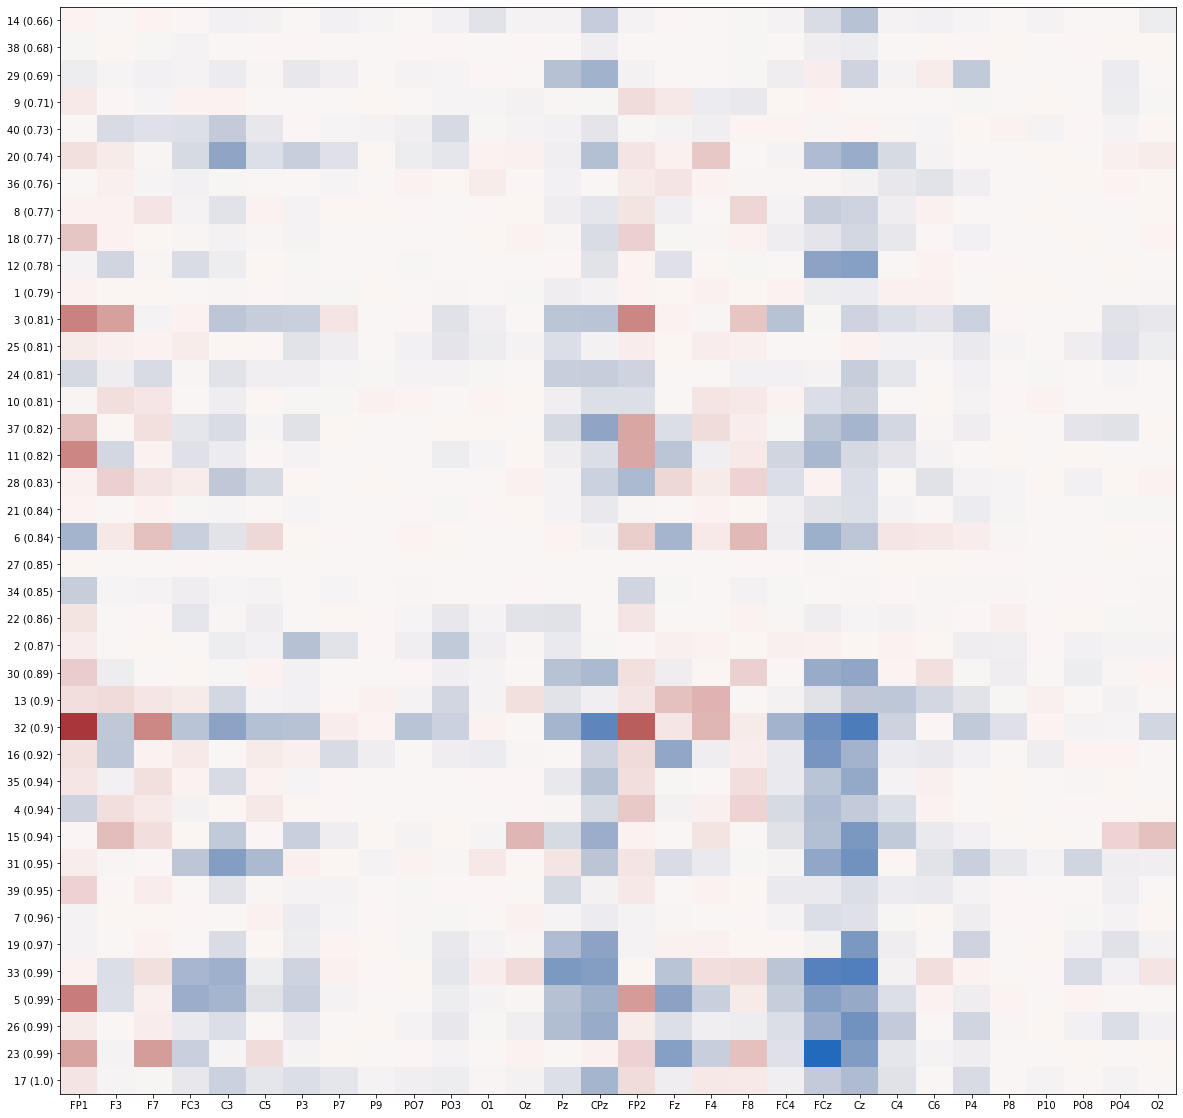

In [65]:
data_path = "F:/Masterthesis/Data/"
preprocessing = "medium"
model_name = "deep"
model_folder = "SubjectAnalysis_Within"
task = "ERN"
split = 2

df = DataLoader.load_df(data_path, task, preprocessing)

attribution = []
for subjectID in range(40): 
    df_cond_one = df[(df["condition"]==1) & (df["subjectID"]==subjectID)]
    data_cond_one, labels_cond_one = DataLoader.create_data_labels(df_cond_one)

    # load model for predictions
    clf, model = Training.init_model(model_name, lr=0.01, gpu=False)
    model_path = os.getcwd()+"\\"+model_folder+"\\"+model_name+"\\"+task+"\\"+preprocessing+"\\"
    clf.load_params(f_params=model_path+"subject_"+str(subjectID)+"_split_"+str(split)+"_model.pkl",
                           f_optimizer=model_path+"subject_"+str(subjectID)+"_split_"+str(split)+"_optimizer.pkl",
                           f_history=model_path+"subject_"+str(subjectID)+"_split_"+str(split)+"_history.json")

    data_tp = data_cond_one[np.where(clf.predict(data_cond_one)==labels_cond_one)[0]]

    dl = DeepLift(model)
    attribution_subject = 0
    for i in range(len(data_tp)):
        tensor = torch.from_numpy(data_tp[i].reshape(1,30,251)).float()
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            attribution_subject+=dl.attribute(tensor, target=1).detach().numpy().mean(axis=2)-dl.attribute(tensor, target=0).detach().numpy().mean(axis=2)
    attribution.append(attribution_subject/(len(data_tp)*10))
    print(subjectID, end =" ")
array = np.concatenate(attribution, axis=0)

# Load Dataframe
df_list = []
model_path = os.getcwd()+"\\"+model_folder+"\\"+model_name+"\\"+task+"\\"+preprocessing+"\\"
for i in range(40):
    df = pd.read_json(model_path+"subject_"+str(i)+"_split_"+str(split)+"_history.json")
    df = df[df["epoch"]==25]
    df["SubjectID"] = i+1
    df["Task"] = task
    df_list.append(df[["Task", "SubjectID", "valid_balanced_accuracy"]])
df = pd.concat(df_list,axis=0)
df["array"] = list(array)
df = df.sort_values("valid_balanced_accuracy")

sns.reset_orig()
plt.figure(figsize=(20, 20))
plt.xticks(np.arange(0, 30, step=1),['FP1','F3','F7','FC3','C3','C5','P3','P7','P9','PO7',
                                     'PO3','O1','Oz','Pz','CPz','FP2','Fz','F4','F8','FC4',
                                     'FCz','Cz','C4','C6','P4','P8','P10','PO8','PO4','O2',])
plt.yticks(np.arange(0, 40, step=1), 
           df["SubjectID"].astype("str")+" ("+np.round(df["valid_balanced_accuracy"],2).astype("str")+")")
vabs = max(abs(array.min()),abs(array.max()))
plt.imshow(np.stack(df["array"].to_numpy()), aspect="auto",cmap="vlag_r", interpolation="none", vmin=-vabs, vmax=vabs)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 

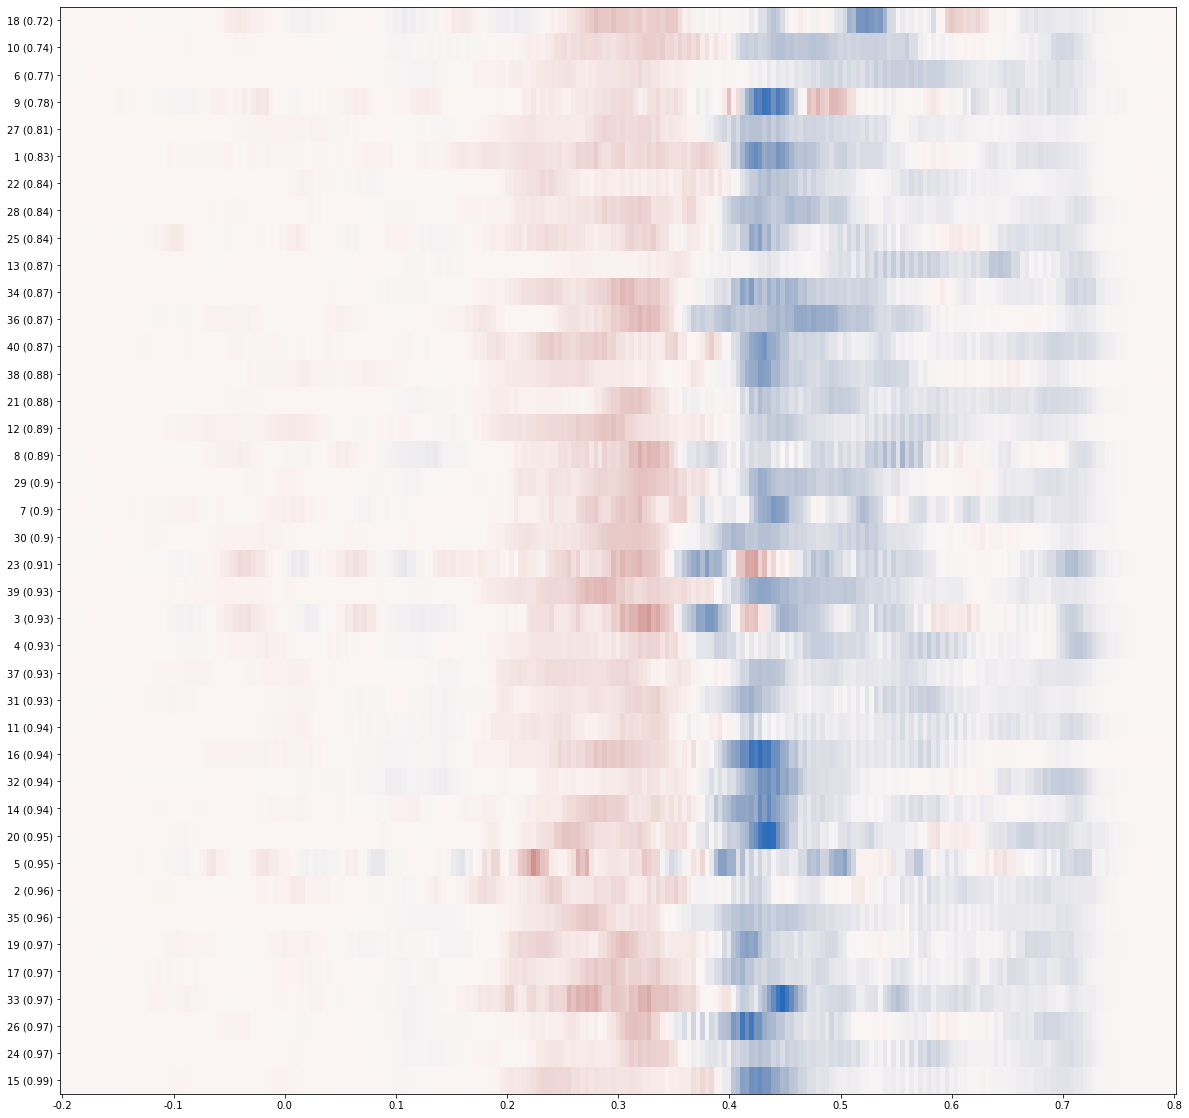

In [66]:
data_path = "F:/Masterthesis/Data/"
preprocessing = "medium"
model_name = "deep"
model_folder = "SubjectAnalysis_Cross"
task = "ERN"

df = DataLoader.load_df(data_path, task, preprocessing)

attribution = []
for subjectID in range(40): 
    df_cond_one = df[(df["condition"]==1) & (df["subjectID"]==subjectID)]
    data_cond_one, labels_cond_one = DataLoader.create_data_labels(df_cond_one)

    # load model for predictions
    clf, model = Training.init_model(model_name, lr=0.01, gpu=False)
    model_path = os.getcwd()+"\\"+model_folder+"\\"+model_name+"\\"+task+"\\"+preprocessing+"\\"
    clf.load_params(f_params=model_path+"split_"+str(subjectID)+"_model.pkl",
                           f_optimizer=model_path+"split_"+str(subjectID)+"_optimizer.pkl",
                           f_history=model_path+"split_"+str(subjectID)+"_history.json")

    data_tp = data_cond_one[np.where(clf.predict(data_cond_one)==labels_cond_one)[0]]

    dl = DeepLift(model)
    attribution_subject = 0
    for i in range(len(data_tp)):
        tensor = torch.from_numpy(data_tp[i].reshape(1,30,251)).float()
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            attribution_subject+=dl.attribute(tensor, target=1).detach().numpy().mean(axis=1)-dl.attribute(tensor, target=0).detach().numpy().mean(axis=1)
    attribution.append(attribution_subject/(len(data_tp)))
    print(subjectID, end =" ")
array = np.concatenate(attribution, axis=0)

# Load Dataframe
df_list = []
model_path = os.getcwd()+"\\"+model_folder+"\\"+model_name+"\\"+task+"\\"+preprocessing+"\\"
for i in range(40):
    df = pd.read_json(model_path+"split_"+str(i)+"_history.json")
    df = df[df["epoch"]==25]
    df["SubjectID"] = i+1
    df["Task"] = task
    df_list.append(df[["Task", "SubjectID", "valid_balanced_accuracy"]])
df = pd.concat(df_list,axis=0)
df["array"] = list(array)
df = df.sort_values("valid_balanced_accuracy")

sns.reset_orig()
plt.figure(figsize=(20, 20))
plt.xticks(np.arange(0, 251, step=25),np.round(np.arange(-0.2, 0.81, step=0.1),2))
plt.yticks(np.arange(0, 40, step=1), 
           df["SubjectID"].astype("str")+" ("+np.round(df["valid_balanced_accuracy"],2).astype("str")+")")
vabs = max(abs(array.min()),abs(array.max()))
plt.imshow(np.stack(df["array"].to_numpy()), aspect="auto",cmap="vlag_r", interpolation="none", vmin=-vabs, vmax=vabs)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 

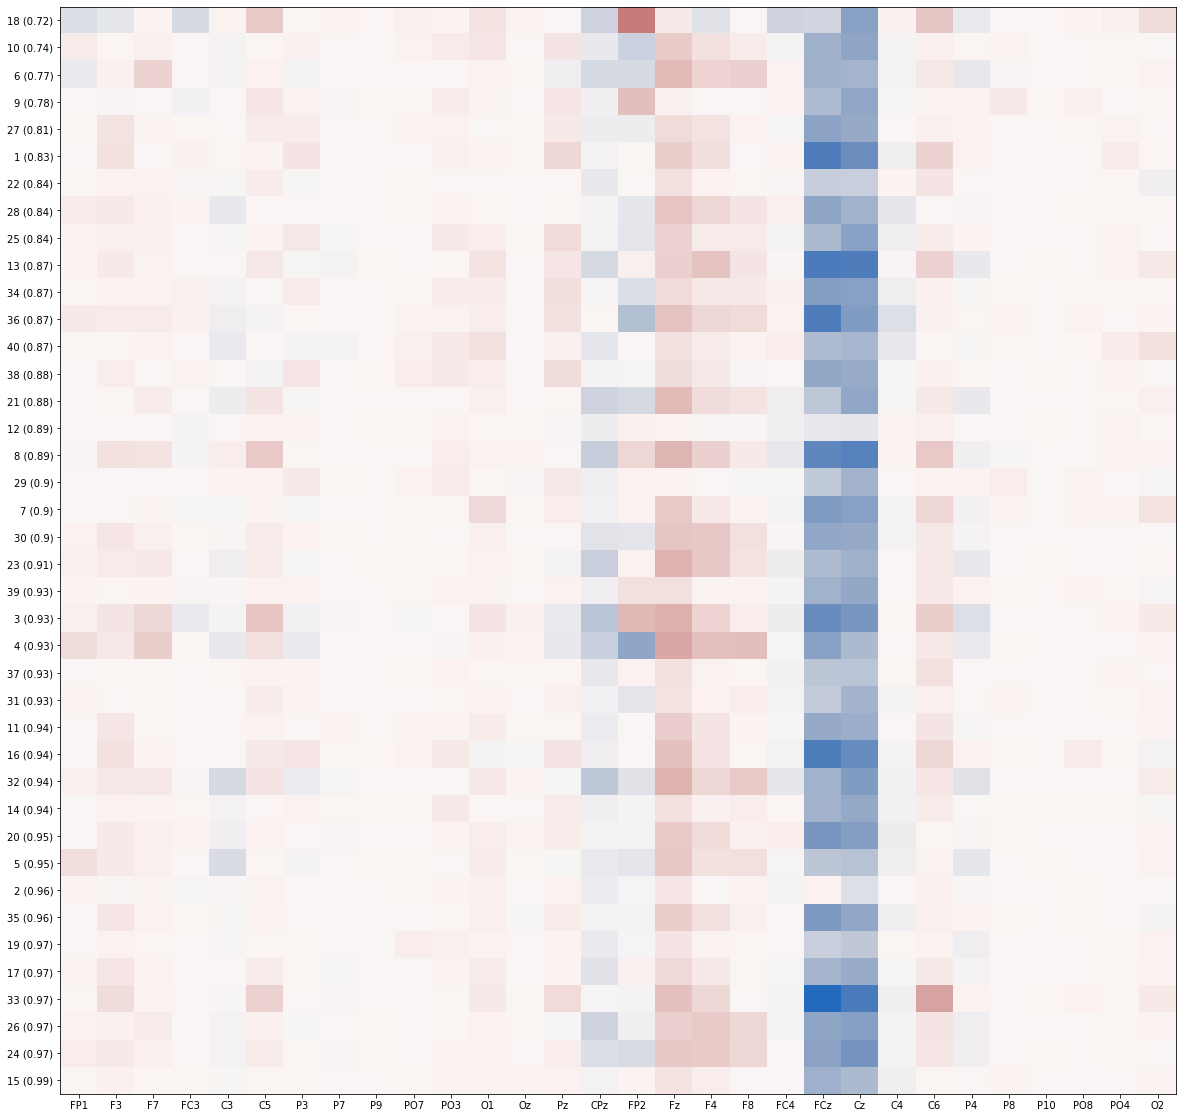

In [67]:
data_path = "F:/Masterthesis/Data/"
preprocessing = "medium"
model_name = "deep"
model_folder = "SubjectAnalysis_Cross"
task = "ERN"

df = DataLoader.load_df(data_path, task, preprocessing)

attribution = []
for subjectID in range(40): 
    df_cond_one = df[(df["condition"]==1) & (df["subjectID"]==subjectID)]
    data_cond_one, labels_cond_one = DataLoader.create_data_labels(df_cond_one)

    # load model for predictions
    clf, model = Training.init_model(model_name, lr=0.01, gpu=False)
    model_path = os.getcwd()+"\\"+model_folder+"\\"+model_name+"\\"+task+"\\"+preprocessing+"\\"
    clf.load_params(f_params=model_path+"split_"+str(subjectID)+"_model.pkl",
                           f_optimizer=model_path+"split_"+str(subjectID)+"_optimizer.pkl",
                           f_history=model_path+"split_"+str(subjectID)+"_history.json")

    data_tp = data_cond_one[np.where(clf.predict(data_cond_one)==labels_cond_one)[0]]

    dl = DeepLift(model)
    attribution_subject = 0
    for i in range(len(data_tp)):
        tensor = torch.from_numpy(data_tp[i].reshape(1,30,251)).float()
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            attribution_subject+=dl.attribute(tensor, target=1).detach().numpy().mean(axis=2)-dl.attribute(tensor, target=0).detach().numpy().mean(axis=2)
    attribution.append(attribution_subject/(len(data_tp)))
    print(subjectID, end =" ")
    
array = np.concatenate(attribution, axis=0)

# Load Dataframe
df_list = []
model_path = os.getcwd()+"\\"+model_folder+"\\"+model_name+"\\"+task+"\\"+preprocessing+"\\"
for i in range(40):
    df = pd.read_json(model_path+"split_"+str(i)+"_history.json")
    df = df[df["epoch"]==25]
    df["SubjectID"] = i+1
    df["Task"] = task
    df_list.append(df[["Task", "SubjectID", "valid_balanced_accuracy"]])
df = pd.concat(df_list,axis=0)
df["array"] = list(array)
df = df.sort_values("valid_balanced_accuracy")

sns.reset_orig()
plt.figure(figsize=(20, 20))
plt.xticks(np.arange(0, 30, step=1),['FP1','F3','F7','FC3','C3','C5','P3','P7','P9','PO7',
                                     'PO3','O1','Oz','Pz','CPz','FP2','Fz','F4','F8','FC4',
                                     'FCz','Cz','C4','C6','P4','P8','P10','PO8','PO4','O2',])
plt.yticks(np.arange(0, 40, step=1), 
           df["SubjectID"].astype("str")+" ("+np.round(df["valid_balanced_accuracy"],2).astype("str")+")")
vabs = max(abs(array.min()),abs(array.max()))
plt.imshow(np.stack(df["array"].to_numpy()), aspect="auto",cmap="vlag_r", interpolation="none", vmin=-vabs, vmax=vabs)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 

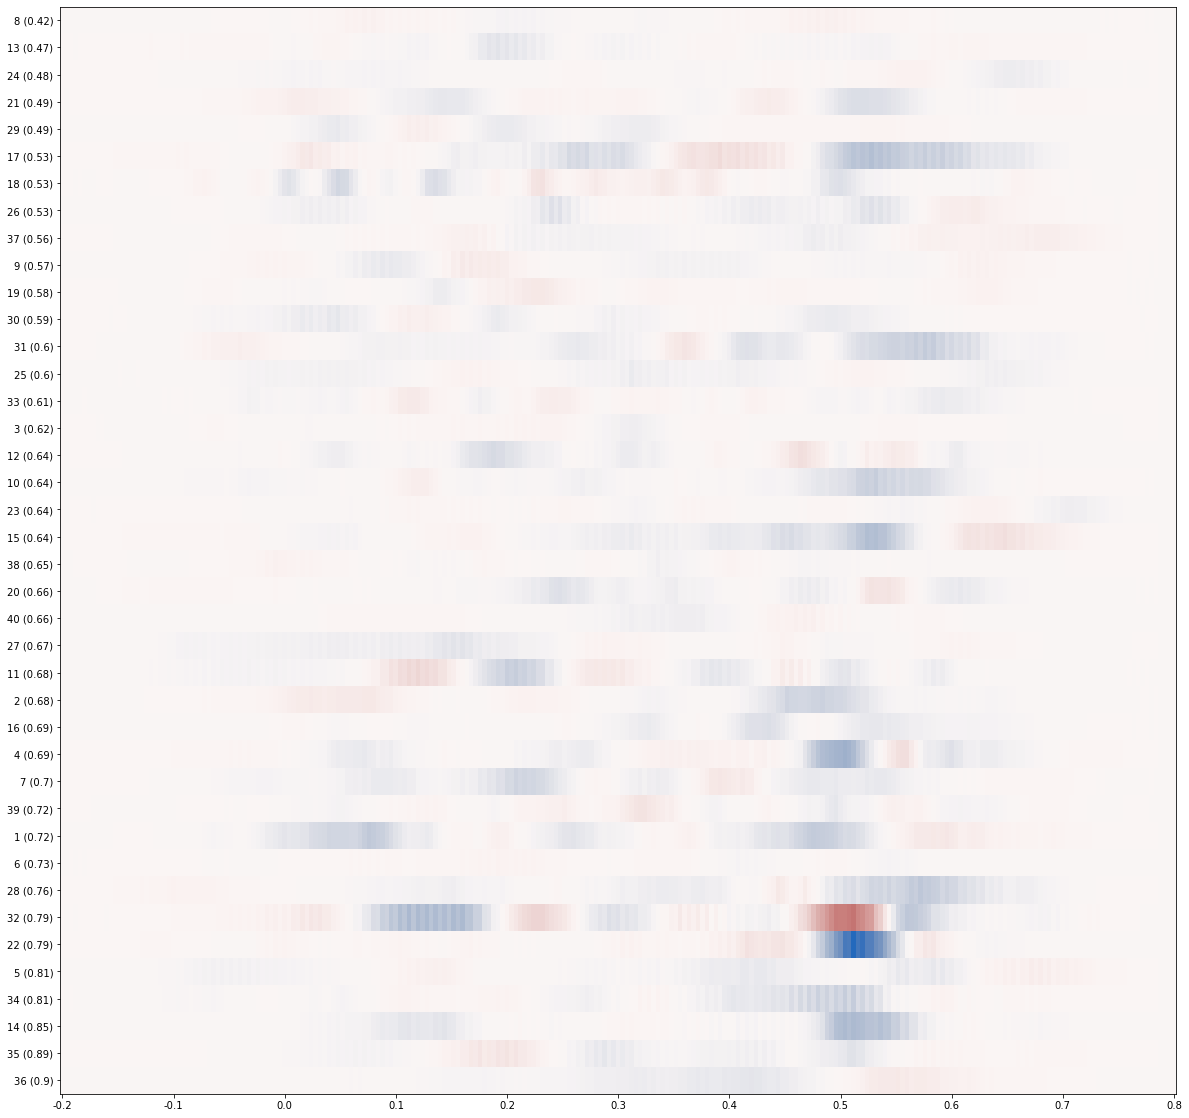

In [70]:
data_path = "F:/Masterthesis/Data/"
preprocessing = "medium"
model_name = "deep"
model_folder = "SubjectAnalysis_Within"
task = "LRP"
split = 2

df = DataLoader.load_df(data_path, task, preprocessing)

attribution = []
for subjectID in range(40): 
    df_cond_one = df[(df["condition"]==1) & (df["subjectID"]==subjectID)]
    data_cond_one, labels_cond_one = DataLoader.create_data_labels(df_cond_one)

    # load model for predictions
    clf, model = Training.init_model(model_name, lr=0.01, gpu=False)
    model_path = os.getcwd()+"\\"+model_folder+"\\"+model_name+"\\"+task+"\\"+preprocessing+"\\"
    clf.load_params(f_params=model_path+"subject_"+str(subjectID)+"_split_"+str(split)+"_model.pkl",
                           f_optimizer=model_path+"subject_"+str(subjectID)+"_split_"+str(split)+"_optimizer.pkl",
                           f_history=model_path+"subject_"+str(subjectID)+"_split_"+str(split)+"_history.json")

    data_tp = data_cond_one[np.where(clf.predict(data_cond_one)==labels_cond_one)[0]]

    dl = DeepLift(model)
    attribution_subject = 0
    for i in range(len(data_tp)):
        tensor = torch.from_numpy(data_tp[i].reshape(1,30,251)).float()
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            attribution_subject+=dl.attribute(tensor, target=1).detach().numpy().mean(axis=1)-dl.attribute(tensor, target=0).detach().numpy().mean(axis=1)
    attribution.append(attribution_subject/(len(data_tp)*10))
    print(subjectID, end =" ")
array = np.concatenate(attribution, axis=0)

# Load Dataframe
df_list = []
model_path = os.getcwd()+"\\"+model_folder+"\\"+model_name+"\\"+task+"\\"+preprocessing+"\\"
for i in range(40):
    df = pd.read_json(model_path+"subject_"+str(i)+"_split_"+str(split)+"_history.json")
    df = df[df["epoch"]==25]
    df["SubjectID"] = i+1
    df["Task"] = task
    df_list.append(df[["Task", "SubjectID", "valid_balanced_accuracy"]])
df = pd.concat(df_list,axis=0)
df["array"] = list(array)
df = df.sort_values("valid_balanced_accuracy")

sns.reset_orig()
plt.figure(figsize=(20, 20))
plt.xticks(np.arange(0, 251, step=25),np.round(np.arange(-0.2, 0.81, step=0.1),2))
plt.yticks(np.arange(0, 40, step=1), 
           df["SubjectID"].astype("str")+" ("+np.round(df["valid_balanced_accuracy"],2).astype("str")+")")
vabs = max(abs(array.min()),abs(array.max()))
plt.savefig("Plots/Within/"+task+"_"+model_name+"_attribution.png")
plt.imshow(np.stack(df["array"].to_numpy()), aspect="auto",cmap="vlag_r", interpolation="none", vmin=-vabs, vmax=vabs)